In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os 
import sys

os.chdir('/Users/miguel/Desktop/')
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

import statsmodels.api as sm
import re
import math

import csv
from scipy.stats import logistic, circmean, vonmises, circstd 

In [8]:
def compute_estimation(dataframe, nbins=41, xlabel='theta', ylabel='theta_est', **kwargs):
    """ Computes the estimation curve given an angular binning with `nbins` bins.
    
    :param pd.DataFrame dataframe: data-frame containing the circular mean of the stimulus orientation along with its estimation by the model.
    :param int nbins: number of bins to divide the angular range and perform the average across trials.
    :param str ylabel: label of the outcome column in the data-frame.
    :param kwargs: additional keyword arguments.
    :return: Returns a tuple (binning: average stimulus orientation, average estimation, standard error).
    :rtype: (pd.Series, pd.Series, pd.Series)
    """
    
    lim = kwargs.pop('lim', np.pi/2)
    # We define the categories for the data points and the model points/line
    dataframe['bin'] = equalbins(dataframe[xlabel], nbins)
    
    # Group the data by the binning and compute the circular mean of the stimulus orientation averages and the 
    # circular mean of the estimated average orientations
    gby_bin = dataframe.groupby('bin')
    x_avg = gby_bin[xlabel].apply(circmean, low=-np.pi, high=np.pi)
    y_avg = gby_bin[ylabel].apply(circmean, low=-np.pi, high=np.pi)
    y_std = gby_bin[ylabel].apply(circstd, low=-np.pi, high=np.pi)
    
    # Select the data inside the desired range
    s_x = x_avg.loc[np.abs(x_avg) <= lim]
    s_y = y_avg.loc[np.abs(x_avg) <= lim]
    s_e = y_std.loc[np.abs(x_avg) <= lim]
    return s_x, s_y, s_e


def circ_dist(x, y):
    return np.angle(np.exp(x * 1j) / np.exp(y * 1j))

# Cleaning functions 

In [3]:
# lib_pdb_analysis.py

def compute_weights_estim(data):
    """Compute stimulus weights 
    
    :param pd.DataFrame data: dataframe containing the simulation results.
    :return: the weights of the different stimulus, their standard errors and their differences for choice and no-choice trials, respectively
    :rtype: (list of float, list of float, list of float)
    """
    choice, no_choice = data.loc[data.do_choice == 1], data.loc[data.do_choice == 0]
    labels = re.findall(r'x[0-9]+\b', '|'.join(data.columns))
    w, wse, dw = [], [], []

    for data in [choice, no_choice]:
        x, y = np.array(data[labels].astype(float)), np.array(data['estim'].astype(float))
        x = sm.add_constant(x, prepend=False)
        
        # Ordinary Least Squares
        res = sm.OLS(y, x).fit()
        w.append(res.params)
        wse.append(res.bse) # standard error of the parameters estimates
        dw.append(np.diff(res.params))  # difference between weights of stimulus

    return w, wse, dw


# lib_analysis.py

def normalize_dataframe(data, copy=False, clean=True, **kwargs):
    """ Post-processing of the dataframe. Normalize and clean the data.

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool copy: whether to do a copy of the data (default=False).
    :param bool clean: whether to clean the data, which means removing columns with labels 'clean_labels' (default=True). 
    :param kwargs: Additional keyword arguments, such as 'clean_labels' or 'normalize_labels'.
    :return: the modified dataframe and the new labels of the stimuli.
    :rtype: (pd.DataFrame, list of str)
    """
    if copy == True: data = data.copy()
    for label in kwargs.get('normalize_labels'):  
        data['norm_%s' % label] = data[label] / 90
    
    # Create columns with normalized [-1, 1] data
    labels = []
    for col in data.columns:
        if re.fullmatch(r'^x[0-9]+', col):  # Only accept columns of the type xXX...X, where X = 0, 1, 2, ..., 9
            labels.append('%s_norm' % col)
            data[labels[-1]] = data[col] / 90  # Normalize the frame orientations

    # Clean the data
    if clean == True:
        try:
            data = data.drop(columns=kwargs.get('clean_labels'))
        except KeyError:
            logging.debug("Cleaning the data-frame failed...")
    return data, labels


# lib_ring.py

def compute_phase(x, n, c=(0.0,), s=(0.0,), wavenumber=1):
    """ Function that gives an approximate value of the phase of a spatial profile by projecting the vector x
    into a cosine function.

    :param Cython.Includes.numpy.ndarray x: firing rates matrix (or vector) with shape (d1, d2, ..., n).
    :param int n: spatial dimension (spatial discretization).
    :param np.ndarray of float c: cosine function, precompute it for faster computation.
    :param np.ndarray of float s: sine function, precompute it for faster computation.
    :param int wavenumber: wavenumber of the corresponding phase that we want to compute.
    :rtype: np.ndarray of float
    """

    # Check external cosine and sine functions
    if len(c) != n or len(s) != n:
        c = np.cos(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)
        s = np.sin(np.arange(n) * wavenumber * 2.0 * np.pi / n - np.pi)

    # norm of sine and cosine functions depends on n (discretization of the space)
    return np.arctan2((np.dot(x, s) / (n / 2.0) ** 2), (np.dot(x, c) / (n / 2.0) ** 2))

In [4]:
opts = {'i_rest': 0.33, 'i_urge':0.5}
urgency_duration = 1.5
cue_duration = 0.750
dt, tmax = 2E-4, 2.05
n = 200
ntrials = 100

tpoints = np.arange(0, tmax, dt)
theta = np.arange(n) / n * (2 * np.pi) - np.pi
nsteps = len(tpoints)

In [5]:
 # Urgency signal (sub-critical pitchfork)
i_rest, i_urge = opts.get('i_rest', 0.33), opts.get('i_urge', 0.50)    # Bistable and pure WTA regimes
go_interval = urgency_duration  # Urgency signal time interval (seconds)
go_signal = cue_duration
go_tstep = int(go_signal / dt)
urgency_signal = np.ones((nsteps, ntrials)) * i_rest
urgency_signal[go_tstep:go_tstep + int(go_interval / dt), np.random.binomial(1, 0.5, ntrials).astype(bool)] = i_urge

In [6]:
save = False

#### Studying the different regimes $(I_0=0.02, 0.05, 0.10, 0.15)$

In [ ]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_bump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')
r_ic_002_bump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.npy')
r_sc_002_bump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.npy')
r_dc_002_bump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)
att_002_bump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.npy')
lri_002_bump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)
us_002_bump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)

In [151]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_ic_005_bump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.npy')
r_sc_005_bump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.npy')
r_dc_005_bump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
att_005_bump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.npy')
lri_005_bump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
us_005_bump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

In [152]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_bump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')
r_ic_010_bump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.npy')
r_sc_010_bump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.npy')
r_dc_010_bump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)
att_010_bump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.npy')
lri_010_bump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)
us_010_bump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)

In [153]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_bump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')
r_ic_015_bump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.npy')
r_sc_015_bump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.npy')
r_dc_015_bump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)
att_015_bump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.npy')
lri_015_bump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)
us_015_bump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_bump_biased_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)

In [181]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')
r_ic_002_nobump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.npy')
r_sc_002_nobump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.npy')
r_dc_002_nobump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)
att_002_nobump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.npy')
lri_002_nobump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)
us_002_nobump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)

In [182]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_ic_005_nobump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.npy')
r_sc_005_nobump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.npy')
r_dc_005_nobump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
att_005_nobump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.npy')
lri_005_nobump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
us_005_nobump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

In [183]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')
r_ic_010_nobump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.npy')
r_sc_010_nobump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.npy')
r_dc_010_nobump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)
att_010_nobump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.npy')
lri_010_nobump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)
us_010_nobump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)

In [184]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump = pd.read_csv('./pdb_simulation_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')
r_ic_015_nobump = np.load('./r_ic_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.npy')
r_sc_015_nobump = np.load('./r_sc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.npy')
r_dc_015_nobump = np.load('./r_dc_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)
att_015_nobump = np.load('./att_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.npy')
lri_015_nobump = np.load('./lri_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)
us_015_nobump = np.load('./us_data_ntrials-1000_oc-range(-90,90,5)_nobump_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)

In [17]:
def compute_decisiontrials(data, r_dc):
    d1, d2 = r_dc[:, 0, :], r_dc[:, 1, :]
    d1_choice, d1_nochoice = np.squeeze(d1[:, np.where(data.do_choice == 1)]), np.squeeze(d1[:, np.where(data.do_choice == 0)])
    d2_choice, d2_nochoice = np.squeeze(d2[:, np.where(data.do_choice == 1)]), np.squeeze(d2[:, np.where(data.do_choice == 0)])
    
    decision_choice = np.sum(np.logical_or((d1_choice[-2, :] + 30 < d2_choice[-2, :]), ((d2_choice[-2, :] + 30 < d1_choice[-2, :]))))
    nodecision_choice = np.sum(np.abs(d1_choice[-2, :] - d2_choice[-2, :]) < 30)
        
    decision_nochoice = np.sum(np.logical_or((d1_nochoice[-2, :] + 30 < d2_nochoice[-2, :]), ((d2_nochoice[-2, :] + 30 < d1_nochoice[-2, :]))))
    nodecision_nochoice = np.sum(np.abs(d1_nochoice[-2, :] - d2_nochoice[-2, :]) < 30)

    return [decision_choice, nodecision_choice], [decision_nochoice, nodecision_nochoice]

In [ ]:
print(compute_decisiontrials(df_002_bump, r_dc_002_bump), 
      compute_decisiontrials(df_005_bump, r_dc_005_bump), 
      compute_decisiontrials(df_010_bump, r_dc_010_bump), 
      compute_decisiontrials(df_015_bump, r_dc_015_bump))

In [ ]:
print(compute_decisiontrials(df_002_nobump, r_dc_002_nobump), 
      compute_decisiontrials(df_005_nobump, r_dc_005_nobump), 
      compute_decisiontrials(df_010_nobump, r_dc_010_nobump), 
      compute_decisiontrials(df_015_nobump, r_dc_015_nobump))

In [15]:
def plot_rdc_lri(data, r_dc, lri, us, idx_nochoice, idx_choice, save=False):
    
    d1, d2 = r_dc[:, 0, :], r_dc[:, 1, :]
    li, ri = lri[:, 0, :], lri[:, 1, :]
    
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(16, 6), gridspec_kw={'height_ratios': [.125, 1.], 'width_ratios': [1., 1.]}, sharex=True, sharey=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.05)
    plt.suptitle('\\textbf{Activity of the decision circuit}', y=0.95, fontsize=25)

    min_dc_nochoice = min(np.min(d1[:-1, idx_nochoice]), np.min(d2[:-1, idx_nochoice]))
    max_dc_nochoice = max(np.max(d1[:-1, idx_nochoice]), np.max(d2[:-1, idx_nochoice]))
    
    min_dc_choice = min(np.min(d1[:-1, idx_choice]), np.min(d2[:-1, idx_choice]))
    max_dc_choice = max(np.max(d1[:-1, idx_choice]), np.max(d2[:-1, idx_choice]))
    
    min_lri_nochoice = min(np.min(li[:-1, idx_nochoice]), np.min(ri[:-1, idx_nochoice]))
    max_lri_nochoice = max(np.max(li[:-1, idx_nochoice]), np.max(ri[:-1, idx_nochoice]))
    
    min_lri_choice = min(np.min(li[:-1, idx_choice]), np.min(ri[:-1, idx_choice]))
    max_lri_choice = max(np.max(li[:-1, idx_choice]), np.max(ri[:-1, idx_choice]))
    
    ax1.fill_between(np.linspace(0, 0.75, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(0.76, 1.75, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(1.76, 2.75, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(2.76, 3.6, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    ax1.annotate('First\n stimulus', (0.125, max_dc_choice + 0.65), fontsize=15, zorder=2) 
    ax1.annotate('Decision period', (0.785, max_dc_choice + 1.3), fontsize=15, zorder=2) 
    ax1.annotate('Delay', (2.1, max_dc_choice + 1.3), fontsize=15, zorder=2) 
    ax1.annotate('Second\n stimulus', (2.9, max_dc_choice + 0.65), fontsize=15, zorder=2) 

    ax1.set_axis_off()
    ax1.spines.top.set_visible(False)
    ax1.spines.bottom.set_visible(False)
    ax1.spines.left.set_visible(False)
    ax1.spines.right.set_visible(False)
    
    ax3.fill_between(np.linspace(0, 0.75, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    ax3.fill_between(np.linspace(0.76, 1.75, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax3.fill_between(np.linspace(1.76, 2.75, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax3.fill_between(np.linspace(2.76, 3.6, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    #ax3.fill_between(np.linspace(0, 0.75, 10), max_rgs + 0.5, max_rgs + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    #ax3.fill_between(np.linspace(0.76, 1.75, 10), max_rgs + 0.5, max_rgs + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    #ax3.fill_between(np.linspace(1.76, 2.75, 10), max_rgs + 0.5, max_rgs + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    #ax3.fill_between(np.linspace(2.76, 3.6, 10), max_rgs + 0.5, max_rgs + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    ax3.annotate('First\n stimulus', (0.125, max_lri_choice + 0.65), fontsize=15, zorder=2) 
    ax3.annotate('Decision period', (0.785, max_lri_choice + 1.3), fontsize=15, zorder=2) 
    ax3.annotate('Delay', (2.1, max_lri_choice + 1.3), fontsize=15, zorder=2) 
    ax3.annotate('Second\n stimulus', (2.9, max_lri_choice + 0.65), fontsize=15, zorder=2) 

    ax3.set_axis_off()
    ax3.spines.top.set_visible(False)
    ax3.spines.bottom.set_visible(False)
    ax3.spines.left.set_visible(False)
    ax3.spines.right.set_visible(False)

    ax2.plot(np.linspace(0, 3.6, d1.shape[0]-1), d1[:-1, idx_nochoice], lw=3, linestyle='dashed', c='blue', zorder=1)
    ax2.plot(np.linspace(0, 3.6, d1.shape[0]-1), d2[:-1, idx_nochoice], lw=3, linestyle='dashed', c='orange', zorder=1)

    ax5 = ax2.twinx()
    ax5.plot(np.linspace(0, 3.6, d1.shape[0]-1), d1[:-1, idx_choice], lw=3, linestyle='solid', c='blue', zorder=2)
    ax5.plot(np.linspace(0, 3.6, d1.shape[0]-1), d2[:-1, idx_choice], lw=3, linestyle='solid', c='orange', zorder=2)
    
    ax4.plot(np.linspace(0, 3.6, li.shape[0]-1), li[:-1, idx_nochoice], lw=3, linestyle='dashed', c='blue')
    ax4.plot(np.linspace(0, 3.6, ri.shape[0]-1), ri[:-1, idx_nochoice], lw=3, linestyle='dashed', c='orange')
    
    ax6 = ax4.twinx()
    ax6.plot(np.linspace(0, 3.6, li.shape[0]-1), li[:-1, idx_choice], lw=3, linestyle='solid', c='blue')
    ax6.plot(np.linspace(0, 3.6, ri.shape[0]-1), ri[:-1, idx_choice], lw=3, linestyle='solid', c='orange')
        
    ax5.fill_between(np.linspace(0, 0.75, 10), min_dc_choice, max_dc_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    ax5.fill_between(np.linspace(0.76, 1.75, 10), min_dc_choice, max_dc_choice, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax5.fill_between(np.linspace(1.76, 2.75, 10), min_dc_choice, max_dc_choice, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax5.fill_between(np.linspace(2.76, 3.6, 10), min_dc_choice, max_dc_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    
    ax6.fill_between(np.linspace(0, 0.75, 10), min_lri_choice, max_lri_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    ax6.fill_between(np.linspace(0.76, 1.75, 10), min_lri_choice, max_lri_choice, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax6.fill_between(np.linspace(1.76, 2.75, 10), min_lri_choice, max_lri_choice, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax6.fill_between(np.linspace(2.76, 3.6, 10), min_lri_choice, max_lri_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    
    ax2.tick_params(axis='both', which='major', labelsize=15)
    ax2.set_xlabel('Time (s)', fontsize=15)
    ax2.set_ylabel('Firing rate for no-choice trials (Hz)', fontsize=15)
    ax2.set_xlim([-0.025, 3.625])
    ax2.set_ylim([min(np.min(d1[:-1, idx_nochoice]), np.min(d2[:-1, idx_nochoice])), max(np.max(d1[:-1, idx_nochoice]), np.max(d2[:-1, idx_nochoice])) + 1])
    
    ax5.set_xlim([-0.025, 3.625])
    ax5.set_ylim([min(np.min(d1[:-1, idx_choice]), np.min(d2[:-1, idx_choice])) - 1, max(np.max(d1[:-1, idx_choice]), np.max(d2[:-1, idx_choice])) + 1])
    ax5.tick_params(axis='both', which='major', labelsize=15)
    ax5.set_ylabel('Firing rate for choice trials (Hz)', fontsize=15)
    
    ax4.tick_params(axis='both', which='major', labelsize=15)
    ax4.set_xlabel('Time (s)', fontsize=15)
    ax4.set_ylabel('Left and right input for no-choice trials', fontsize=15)
    ax4.set_xlim([-0.025, 3.625])    
    ax4.set_ylim([min_lri_nochoice - 0.0006, max_lri_nochoice + 0.0006])
    
    ax6.set_xlim([-0.025, 3.625])
    ax6.tick_params(axis='both', which='major', labelsize=15)
    ax6.set_xlim([-0.025, 3.625]) 
    ax6.set_ylim([min_lri_choice - 0.0006, max_lri_choice + 0.0006])
    ax6.set_ylabel('Left and right input for choice trials', fontsize=15)
        
    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/dc_lri.svg', 
                    format='svg', transparent=True)

    return fig, [ax1, ax2, ax3, ax4, ax5]

In [16]:
fig, [ax1, ax2, ax3, ax4, ax5] = plot_rdc_lri(df_010_nobump, r_dc_010_nobump, lri_010_nobump, us_010_nobump, idx_nochoice=5, idx_choice=1, save=True)

NameError: name 'df_010_nobump' is not defined

In [19]:
def plot_estimation_weights(data, save=False):
    """ Plotting of the estimation curves and the weights on the estimation of the different stimulus

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool save: whether to save the graphics or not
    :return: the estimation curves as a function of the first stimulus and the weights of the different stimulus
    :rtype: 
    """
    
    # for the estimation curves
    avg_nochoice = data[data.do_choice == 0].loc[:, ['average', 'estim']].groupby('average').apply(circmean, low=-180, high=180).index.values
    est_nochoice = data[data.do_choice == 0].loc[:, ['average', 'estim']].groupby('average').apply(circmean, low=-180, high=180).values        
    std_nochoice = data[data.do_choice == 0].loc[:, ['average', 'estim']].groupby('average').apply(circstd, low=-180, high=180).values

    avg_choice = data[data.do_choice == 1].loc[:, ['average', 'estim']].groupby('average').apply(circmean, low=-180, high=180).index.values
    est_choice = data[data.do_choice == 1].loc[:, ['average', 'estim']].groupby('average').apply(circmean, low=-180, high=180).values
    std_choice = data[data.do_choice == 1].loc[:, ['average', 'estim']].groupby('average').apply(circstd, low=-180, high=180).values
    
    # for the plot of the weights
    w, we, _ = compute_weights_estim(data)
    w_choice, w_nochoice = np.array([w[0][0], w[0][1]]), np.array([w[1][0], w[1][1]])
    we_choice, we_nochoice = np.array([we[0][0], we[0][1]]), np.array([we[1][0], we[1][1]])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.75, 1]})

    ax1.plot(avg_nochoice, est_nochoice, c='orange', linestyle='solid', alpha=1, lw=3.5, zorder=2)
    ax1.fill_between(avg_nochoice, est_nochoice - std_nochoice, est_nochoice + std_nochoice, color='orange', alpha=0.2, label='_nolegend_', zorder=2)
    ax1.plot(avg_choice, est_choice, c='blue', linestyle='solid', alpha=1, lw=3.5, zorder=3)
    ax1.fill_between(avg_choice, est_choice - std_choice, est_choice + std_choice, color='blue', alpha=0.2, label='_nolegend_', zorder=3)
    ax1.plot(np.linspace(np.min([data.x1, data.x2]), np.max([data.x1, data.x2]), 100), 
             np.linspace(np.min([data.x1, data.x2]), np.max([data.x1, data.x2]), 100), '--', c='grey', lw=1)
    
    #ax1.set_yticks(np.arange(np.min([data.x1, data.x2]), np.max([data.x1, data.x2]), 20))
    ax1.set_yticks(np.arange(-80, 81, 20))
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.set_xlabel('Average stimulus orientation $(^\circ)$', fontsize=15)
    ax1.set_ylabel('Average stimulus estimation $(^\circ)$', fontsize=15)

    ax1.set_title('\\textbf{Estimation curves}', fontsize=20)
    ax1.legend(['No choice', 'Choice'], fontsize=12.5)
    ax1.set_xlim([np.min([data.x1, data.x2]) - 1, np.max([data.x1, data.x2]) + 1])
    ax1.set_ylim([np.min([np.concatenate([est_nochoice - std_nochoice, est_choice - std_choice])]) - 2,   
                  np.max([np.concatenate([est_nochoice + std_nochoice, est_choice + std_choice])]) + 2])

    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_nochoice, lw=1.5, c='orange')
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_choice, lw=1.5, c='blue')

    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_nochoice, lw=3, c='orange')
    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_choice, lw=3, c='blue')

    ax2.annotate(w_choice[0].round(3), (0, w_choice[0]), fontsize=12) 
    ax2.annotate(w_nochoice[0].round(3), (0, w_nochoice[0]), fontsize=12) 
    ax2.annotate(w_choice[1].round(3), (1, w_choice[1]), fontsize=12) 
    ax2.annotate(w_nochoice[1].round(3), (1, w_nochoice[1]), fontsize=12) 

    ax2.spines.top.set_visible(False)
    ax2.spines.bottom.set_visible(True)
    ax2.spines.left.set_visible(True)
    ax2.spines.right.set_visible(False)
    ax2.spines.bottom.set_bounds((0, 1))
    ax2.tick_params(axis='both', which='major', labelsize=15)

    ax2.set_title('\\textbf{Stimulus weights}', fontsize=20)
    ax2.legend(['No choice', 'Choice'], fontsize=12.5)
        
    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/est_weights_i0-0.02_bump_biased.pdf', 
                    format='pdf', transparent=True)

    return fig, [ax1, ax2]

def plot_bump_ic(data, r_IC, ntrial, save=False):
    """ Plotting of the estimation curves and the weights on the estimation of the different stimulus

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool save: whether to save the graphics or not
    :return: the bump profile of activity of the firing rate of the integration circuit
    :rtype: 
    """
    
    ntrial = ntrial
    print(f'Do choice? {data.do_choice[ntrial].astype(bool)}')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(7, 6))
    
    plt.subplots_adjust(wspace=0, hspace=0.05)
    plt.suptitle('\\textbf{Firing rate of the integration circuit}', y=0.925, fontsize=20)

    max_fr = np.max([r_IC[0, ntrial, :], r_IC[85, ntrial, :], r_IC[270, ntrial, :], r_IC[-2, ntrial, :]])

    ax1.scatter(data.ph1[ntrial], max_fr + 10, marker='v', color='dodgerblue', s=300, alpha=1., zorder=1, label='_nolegend_')
    ax1.scatter(data.ph_last[ntrial], max_fr + 10, marker='v', color='darkblue', s=300, alpha=1., zorder=2, label='_nolegend_')
    ax1.scatter(data.average[ntrial], max_fr + 10, marker='v', color='red', s=300, alpha=1., zorder=2, label='_nolegend_')
    #ax1.annotate('Estimation', (data.ph_last[ntrial] - 20, max_fr + 8.5), color='darkblue', fontsize=15) 
    #ax1.annotate('Mean\n orientation', (data.average[ntrial], max_fr + 6), color='red', fontsize=15) 

    ax1.plot(np.linspace(-180, 180, 200), r_IC[0, ntrial, :], c='lightblue', lw=3, zorder=1)
    ax1.plot(np.linspace(-180, 180, 200), r_IC[85, ntrial, :], c='dodgerblue', lw=3, zorder=2)
    ax1.plot(np.linspace(-180, 180, 200), r_IC[270, ntrial, :], c='dodgerblue', linestyle='dashed', lw=3, zorder=2)
    ax1.plot(np.linspace(-180, 180, 200), r_IC[-2, ntrial, :], c='darkblue', lw=3, zorder=3)
 
    ax1.vlines(data.ph1[ntrial],  max(r_IC[85, ntrial, :]),  max_fr + 10, color='dodgerblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')
    ax1.vlines(data.ph_last[ntrial],  max(r_IC[-2, ntrial, :]),  max_fr + 10, color='darkblue', lw=1.25, zorder=1, linestyle='dashed', label='_nolegend_')

    ax1.spines.top.set_visible(False)
    ax1.spines.bottom.set_visible(True)
    ax1.spines.left.set_visible(True)
    ax1.spines.right.set_visible(False)

    ax1.set_xlim([-180, 180])

    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.legend(['0 s', '0.75 s', '2.75', '3.5 s'], fontsize=13, loc='best')
    ax1.set_xlabel('Preferred orientation of neurons $(^\circ)$', fontsize=17.5)
    ax1.set_ylabel('Firing rate (Hz)', fontsize=17.5)

    ax1.set_ylim(bottom=-0.25)
    ax1.set_yticks(np.arange(0, math.ceil(max_fr), 10))
    ax1.spines.left.set_bounds((0, math.ceil(max_fr)))
    ax1.xaxis.labelpad = 7.5

    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/fr_i0-0.05_bump_dochoice-{data.do_choice[ntrial].astype(bool)}_{ntrial}.pdf', 
                    format='pdf', transparent=True)
    
    return fig, [ax1]


def plot_amplitude(amp_002, amp_005, amp_010, amp_015, 
                   data_002, data_005, data_010, data_015, 
                   min_rgs, max_rgs, 
                   bump=False, ntrials=1000, sigma_ou=0.15, min_oc=-90, max_oc=90, step_oc=5, nframes=2, save='False'):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [.125, 1.]}, sharex=True, sharey=False)
    plt.subplots_adjust(wspace=0, hspace=0.05)
    plt.suptitle('\\textbf{Amplitude vs time}', y=0.925, fontsize=20)

    ax1.fill_between(np.linspace(0, 0.75, 10), max_rgs + 0.5, max_rgs + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(0.76, 1.75, 10), max_rgs + 0.5, max_rgs + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(1.76, 2.75, 10), max_rgs + 0.5, max_rgs + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(2.76, 3.6, 10), max_rgs + 0.5, max_rgs + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    ax1.annotate('First\n stimulus', (0.15, 21.65), fontsize=15, zorder=2) 
    ax1.annotate('Decision period', (0.825, 22.35), fontsize=15, zorder=2) 
    ax1.annotate('Delay', (2.1, 22.35), fontsize=15, zorder=2) 
    ax1.annotate('Second\n stimulus', (2.95, 21.65), fontsize=15, zorder=2) 

    ax1.set_axis_off()
    ax1.spines.top.set_visible(False)
    ax1.spines.bottom.set_visible(False)
    ax1.spines.left.set_visible(False)
    ax1.spines.right.set_visible(False)

    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_002[:, np.where(data_002.do_choice == 1)])), axis=1)[:-1], c='blue', 
             linestyle='dashdot', label='_nolegend_', zorder=3)
    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_002[:, np.where(data_002.do_choice == 0)])), axis=1)[:-1], c='orange', 
             linestyle='dashdot', label='_nolegend_', zorder=2)

    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_005[:, np.where(data_005.do_choice == 1)])), axis=1)[:-1], c='blue', 
             linestyle='dashed', label='_nolegend_', zorder=3)
    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_005[:, np.where(data_005.do_choice == 0)])), axis=1)[:-1], c='orange', 
             linestyle='dashed', label='_nolegend_', zorder=2)


    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_010[:, np.where(data_010.do_choice == 1)])), axis=1)[:-1], c='blue', 
             linestyle='solid', zorder=3)
    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_010[:, np.where(data_010.do_choice == 0)])), axis=1)[:-1], c='orange', 
             linestyle='solid', zorder=2)
    
    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_015[:, np.where(data_015.do_choice == 1)])), axis=1)[:-1], c='blue', 
             linestyle='dotted', label='_nolegend_', zorder=3)
    ax2.plot(np.linspace(0, 3.6, 359), 2 * np.mean(abs(np.squeeze(amp_015[:, np.where(data_015.do_choice == 0)])), axis=1)[:-1], c='orange', 
             linestyle='dotted', label='_nolegend_', zorder=2)
        
    ax2.fill_between(np.linspace(0, 0.75, 10), 2 * min_rgs, 2 * max_rgs, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    ax2.fill_between(np.linspace(0.76, 1.75, 10), 2 * min_rgs, 2 * max_rgs, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax2.fill_between(np.linspace(1.76, 2.75, 10), 2 * min_rgs, 2 * max_rgs, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax2.fill_between(np.linspace(2.76, 3.6, 10), 2 * min_rgs, 2 * max_rgs, color='black', alpha=0.05, zorder=1, label='_nolegend_')

    ax2.tick_params(axis='both', which='major', labelsize=15)
    ax2.legend(['Choice', 'No choice'], fontsize=13, loc='best')
    ax2.set_xlabel('Time (s)', fontsize=15)
    ax2.set_ylabel('Maximum of firing rate (Hz)', fontsize=15)

    ax2.set_xlim([-0.025, 3.625])
    ax2.set_ylim([2 * min_rgs - 0.25, 2 * max_rgs + 0.25])
    
    if save == True:
        if bump == True:
            plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/amplitude_ntrials-{ntrials}_oc-range({min_oc},{max_oc},{step_oc})_bump_biased' + 
                        f'_sigma-{sigma_ou}_frames-{nframes}_t.pdf', format='pdf')
        if bump == False:
            plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/amplitude_ntrials-{ntrials}_oc-range({min_oc},{max_oc},{step_oc})_nobump' + 
                        f'_sigma-{sigma_ou}_frames-{nframes}_t.pdf', format='pdf')
        
        
def compute_amplitude(data, r_IC, n):
    theta = np.arange(n) / n * 2 * np.pi - np.pi
    
    amp = 1 / (2 * np.pi) * np.sum(r_IC * np.exp(-1 * theta * 1.j) * np.diff(theta)[0], axis=2)
    minimum = np.min([np.mean(np.abs(np.squeeze(amp[:, np.where(data.do_choice == 1)])), axis=1)[:-1], 
                      np.mean(np.abs(np.squeeze(amp[:, np.where(data.do_choice == 0)])), axis=1)[:-1]]) 
    maximum = np.max([np.mean(np.abs(np.squeeze(amp[:, np.where(data.do_choice == 1)])), axis=1)[:-1], 
                      np.mean(np.abs(np.squeeze(amp[:, np.where(data.do_choice == 0)])), axis=1)[:-1]]) 
    
    return amp, minimum, maximum

In [ ]:
fig, ax1 = plot_bump_ic(df_005_bump, r_ic_005_bump, ntrial=10, save=True)

/Users/miguel/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


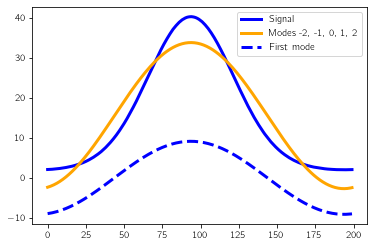

In [41]:
plt.plot(r_ic_002_bump[85, 1], lw=3, c='blue')
plt.plot(1 / (2 * np.pi) * (np.sum(r_ic_002_bump[85, 1] * np.exp(-1 * theta * 1j) * np.diff(theta)[0]) * np.exp(1j * theta) + 
                            np.sum(r_ic_002_bump[85, 1] * np.exp(-0 * theta * 1j) * np.diff(theta)[0]) * np.exp(0j * theta) +
                            np.sum(r_ic_002_bump[85, 1] * np.exp(1 * theta * 1j) * np.diff(theta)[0]) * np.exp(-1j * theta)
                           ), c='orange', lw=3) 
plt.plot(1 / (2 * np.pi) * (np.sum(r_ic_002_bump[85, 1] * np.exp(-1 * theta * 1.j) * np.diff(theta)[0]) * np.exp(1.j * theta) 
                           ), c='blue', linestyle='dashed', lw=3) 

plt.legend(['Signal', 'Modes -2, -1, 0, 1, 2', 'First mode'])
plt.show()

In [178]:
amp_002_bump, min_002_bump, max_002_bump = compute_amplitude(df_002_bump, r_ic_002_bump, n=200)
amp_005_bump, min_005_bump, max_005_bump = compute_amplitude(df_005_bump, r_ic_005_bump, n=200)
amp_010_bump, min_010_bump, max_010_bump = compute_amplitude(df_010_bump, r_ic_010_bump, n=200)
amp_015_bump, min_015_bump, max_015_bump = compute_amplitude(df_015_bump, r_ic_015_bump, n=200)

max_rgs = max(max_002_bump, max_005_bump, max_010_bump, max_015_bump)
min_rgs = min(min_002_bump, min_005_bump, min_010_bump, min_015_bump)

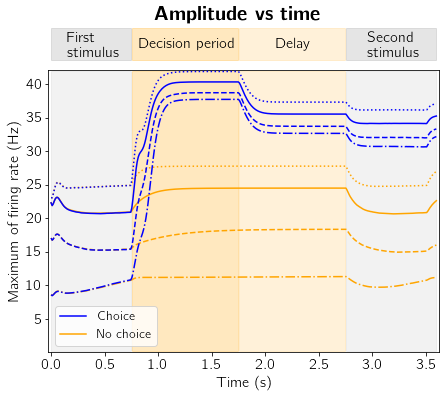

In [215]:
plot_amplitude(amp_002_bump, amp_005_bump, amp_010_bump, amp_015_bump, 
               df_002_bump, df_005_bump, df_010_bump, df_015_bump, 
               min_rgs, max_rgs, 
               bump=True, ntrials=300, save=True)

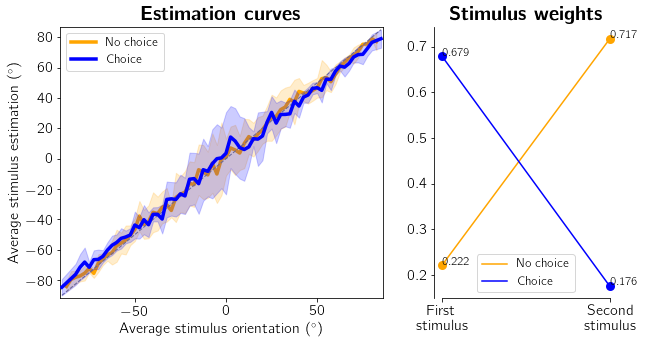

In [220]:
fig, [ax1, ax2] = plot_estimation_weights(df_002_bump, save=True)

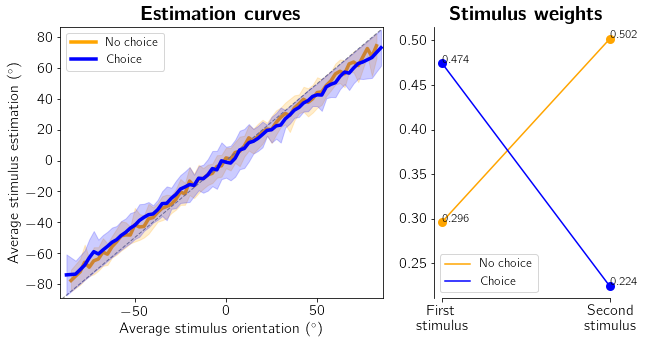

In [221]:
fig, [ax1, ax2] = plot_estimation_weights(df_005_bump, save=True)

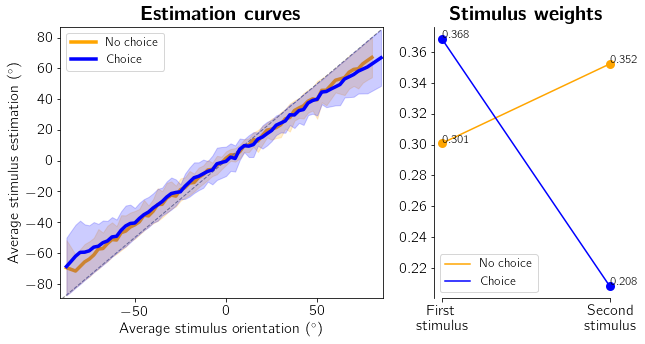

In [222]:
fig, [ax1, ax2] = plot_estimation_weights(df_010_bump, save=True)

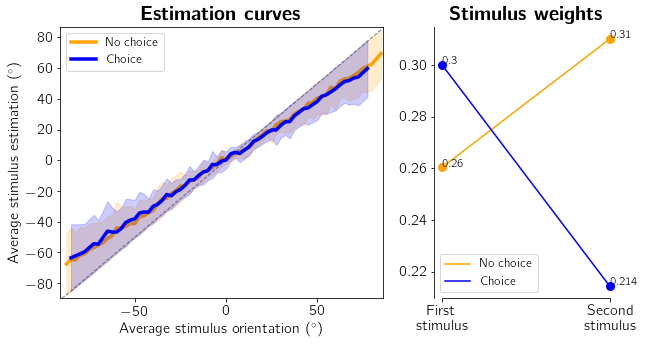

In [223]:
fig, [ax1, ax2] = plot_estimation_weights(df_015_bump, save=True)

In [199]:
amp_002_nobump, min_002_nobump, max_002_nobump = compute_amplitude(df_002_nobump, r_ic_002_nobump, n=200)
amp_005_nobump, min_005_nobump, max_005_nobump = compute_amplitude(df_005_nobump, r_ic_005_nobump, n=200)
amp_010_nobump, min_010_nobump, max_010_nobump = compute_amplitude(df_010_nobump, r_ic_010_nobump, n=200)
amp_015_nobump, min_015_nobump, max_015_nobump = compute_amplitude(df_015_nobump, r_ic_015_nobump, n=200)

max_rgs = max(max_002_nobump, max_005_nobump, max_010_nobump, max_015_nobump)
min_rgs = min(min_002_nobump, min_005_nobump, min_010_nobump, min_015_nobump)

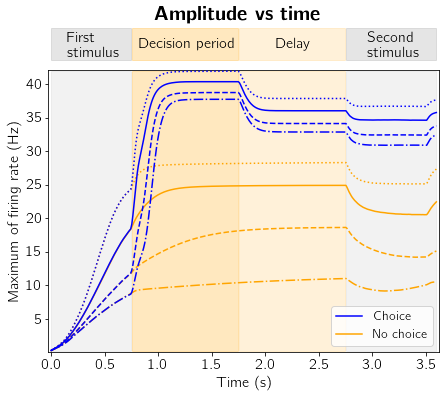

In [224]:
plot_amplitude(amp_002_nobump, amp_005_nobump, amp_010_nobump, amp_015_nobump, 
               df_002_nobump, df_005_nobump, df_010_nobump, df_015_nobump, 
               min_rgs, max_rgs, 
               bump=False, ntrials=300, save=True)

In [232]:
w_002_bump, we_002_bump, dw_002_bump = compute_weights_estim(df_002_bump)
w_005_bump, we_005_bump, dw_005_bump = compute_weights_estim(df_005_bump)
w_010_bump, we_010_bump, dw_010_bump = compute_weights_estim(df_010_bump)
w_015_bump, we_015_bump, dw_015_bump = compute_weights_estim(df_015_bump)

w_002_nobump, we_002_nobump, dw_002_nobump = compute_weights_estim(df_002_nobump)
w_005_nobump, we_005_nobump, dw_005_nobump = compute_weights_estim(df_005_nobump)
w_010_nobump, we_010_nobump, dw_010_nobump = compute_weights_estim(df_010_nobump)
w_015_nobump, we_015_nobump, dw_015_nobump = compute_weights_estim(df_015_nobump)

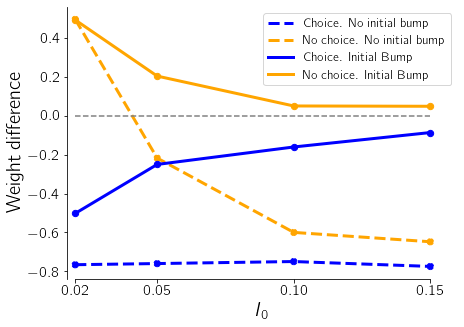

In [233]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[0], dw_005_nobump[0], dw_010_nobump[0], 
                                                       dw_015_nobump[0]]), linestyle='dashed', lw=3, c='blue', zorder=1)
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[1], dw_005_nobump[1], dw_010_nobump[1], 
                                                       dw_015_nobump[1]]), linestyle='dashed', lw=3, c='orange', zorder=1)
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_bump[0], dw_005_bump[0], dw_010_bump[0], 
                                                       dw_015_bump[0]]), linestyle='solid', lw=3, c='blue', zorder=1)
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_bump[1], dw_005_bump[1], dw_010_bump[1], 
                                                       dw_015_bump[1]]), linestyle='solid', lw=3, c='orange', zorder=1)
ax1.plot(np.linspace(0.02, 0.15, 50), np.repeat(0, 50), lw=1.5, linestyle='dashed', c='grey', zorder=1)

ax1.scatter(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[0], dw_005_nobump[0], dw_010_nobump[0], 
                                                       dw_015_nobump[0]]), linestyle='dashed', s=40, c='blue', facecolors='none', zorder=2)
ax1.scatter(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[1], dw_005_nobump[1], dw_010_nobump[1], 
                                                       dw_015_nobump[1]]), linestyle='dashed', s=40, c='orange', facecolors='none', zorder=2)
ax1.scatter(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_bump[0], dw_005_bump[0], dw_010_bump[0], 
                                                       dw_015_bump[0]]), linestyle='solid', s=40, c='blue', facecolors='none', zorder=2)
ax1.scatter(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_bump[1], dw_005_bump[1], dw_010_bump[1], 
                                                       dw_015_bump[1]]), linestyle='solid', s=40, c='orange', facecolors='none', zorder=2)


ax1.set_xticks(np.array([0.02, 0.05, 0.10, 0.15]))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('$I_0$', fontsize=20)
ax1.set_ylabel('Weight difference', fontsize=20)

ax1.legend(['Choice. No initial bump', 'No choice. No initial bump', 'Choice. Initial Bump', 'No choice. Initial Bump'], fontsize=12.5)

ax1.set_xlim([0.017, 0.16])
ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(True)
ax1.spines.left.set_visible(True)
ax1.spines.right.set_visible(False)
ax1.spines.bottom.set_bounds((0.02, 0.15))
ax1.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/weights.pdf', format='pdf')
plt.show()

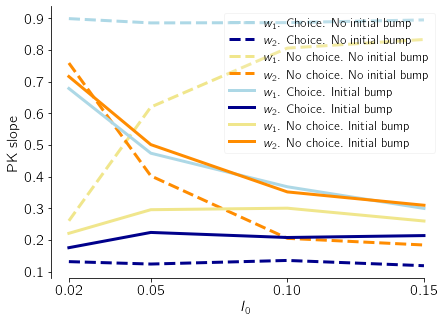

In [43]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_nobump[0][0], w_005_nobump[0][0], w_010_nobump[0][0], 
                                                       w_015_nobump[0][0]]), linestyle='dashed', lw=3, c='lightblue')
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_nobump[0][1], w_005_nobump[0][1], w_010_nobump[0][1], 
                                                       w_015_nobump[0][1]]), linestyle='dashed', lw=3, c='darkblue')

ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_nobump[1][0], w_005_nobump[1][0], w_010_nobump[1][0], 
                                                       w_015_nobump[1][0]]), linestyle='dashed', lw=3, c='khaki')
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_nobump[1][1], w_005_nobump[1][1], w_010_nobump[1][1], 
                                                       w_015_nobump[1][1]]), linestyle='dashed', lw=3, c='darkorange')

ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_bump[0][0], w_005_bump[0][0], w_010_bump[0][0], 
                                                       w_015_bump[0][0]]), linestyle='solid', lw=3, c='lightblue')
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_bump[0][1], w_005_bump[0][1], w_010_bump[0][1], 
                                                       w_015_bump[0][1]]), linestyle='solid', lw=3, c='darkblue')

ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_bump[1][0], w_005_bump[1][0], w_010_bump[1][0], 
                                                       w_015_bump[1][0]]), linestyle='solid', lw=3, c='khaki')
ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([w_002_bump[1][1], w_005_bump[1][1], w_010_bump[1][1], 
                                                       w_015_bump[1][1]]), linestyle='solid', lw=3, c='darkorange')

ax1.set_xticks(np.array([0.02, 0.05, 0.10, 0.15]))
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('$I_0$', fontsize=15)
ax1.set_ylabel('PK slope', fontsize=15)

ax1.legend(['$w_1$. Choice. No initial bump', '$w_2$. Choice. No initial bump', '$w_1$. No choice. No initial bump', '$w_2$. No choice. No initial bump', 
            '$w_1$. Choice. Initial bump', '$w_2$. Choice. Initial bump', '$w_1$. No choice. Initial bump', '$w_2$. No choice. Initial bump'], fontsize=12.5, 
           framealpha=0.2)

ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(True)
ax1.spines.left.set_visible(True)
ax1.spines.right.set_visible(False)
ax1.spines.bottom.set_bounds((0.02, 0.15))
ax1.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [32]:
### Changing functions for the tfm

In [280]:
def plot_estimation_weights(data, save=False):
    """ Plotting of the estimation curves and the weights on the estimation of the different stimulus

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool save: whether to save the graphics or not
    :return: the estimation curves as a function of the first stimulus and the weights of the different stimulus
    :rtype: 
    """
    
    # for the estimation curves
    avg_nochoice = data[data.do_choice == 0].loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_nochoice = data[data.do_choice == 0].loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values        
    std_nochoice = data[data.do_choice == 0].loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_choice = data[data.do_choice == 1].loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_choice = data[data.do_choice == 1].loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_choice = data[data.do_choice == 1].loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values
    
    # for the plot of the weights
    w, we, _ = compute_weights_estim(data)
    w_choice, w_nochoice = np.array([w[0][0], w[0][1]]), np.array([w[1][0], w[1][1]])
    we_choice, we_nochoice = np.array([we[0][0], we[0][1]]), np.array([we[1][0], we[1][1]])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.75, 1]})
    
    plt.subplots_adjust(wspace=0.3)

    ax1.plot(avg_nochoice, est_nochoice, c='orange', linestyle='solid', alpha=1, lw=3.5, zorder=2)
    ax1.fill_between(avg_nochoice, est_nochoice - std_nochoice, est_nochoice + std_nochoice, color='orange', alpha=0.2, label='_nolegend_', zorder=2)
    ax1.plot(avg_choice, est_choice, c='blue', linestyle='solid', alpha=1, lw=3.5, zorder=3)
    ax1.fill_between(avg_choice, est_choice - std_choice, est_choice + std_choice, color='blue', alpha=0.2, label='_nolegend_', zorder=3)
    ax1.plot(np.linspace(np.min([data.x1, data.x2]), np.max([data.x1, data.x2]), 100), 
             np.linspace(np.min([data.x1, data.x2]), np.max([data.x1, data.x2]), 100), '--', c='grey', lw=1)
    
    ax1.set_yticks(np.arange(np.min([data.x1, data.x2]), np.max([data.x1, data.x2]) + 10, 10))
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.set_xlabel('Average stimulus orientation $(^\circ)$', fontsize=15, labelpad = 10)
    ax1.set_ylabel('Average stimulus estimation $(^\circ)$', fontsize=15)

    ax1.set_title('\\textbf{Estimation curves}', fontsize=20)
    ax1.legend(['No choice', 'Choice'], fontsize=12.5)
    ax1.set_xlim([np.min([data.x1, data.x2]) - 1, np.max([data.x1, data.x2]) + 1])
    ax1.set_ylim([np.min([np.concatenate([est_nochoice - std_nochoice, est_choice - std_choice])]) - 2,   
                  np.max([np.concatenate([est_nochoice + std_nochoice, est_choice + std_choice])]) + 2])
    
    ax1.grid(color = 'grey', linestyle = 'dashed', linewidth = 0.5)

    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_nochoice, lw=1.5, c='orange')
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_choice, lw=1.5, c='blue')

    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_nochoice, lw=3, c='orange')
    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_choice, lw=3, c='blue')
    
    ax2.annotate(w_choice[0].round(3), (0, w_choice[0]), fontsize=12) 
    ax2.annotate(w_nochoice[0].round(3), (0, w_nochoice[0]), fontsize=12) 
    ax2.annotate(w_choice[1].round(3), (1, w_choice[1]), fontsize=12) 
    ax2.annotate(w_nochoice[1].round(3), (1, w_nochoice[1]), fontsize=12) 

    ax2.spines.top.set_visible(False)
    ax2.spines.bottom.set_visible(True)
    ax2.spines.left.set_visible(True)
    ax2.spines.right.set_visible(False)
    ax2.spines.bottom.set_bounds((0, 1))
    ax2.tick_params(axis='both', which='major', labelsize=15)
    
    ax2.set_ylabel('Weights', fontsize=15)
    ax2.set_title('\\textbf{Stimulus weights}', fontsize=20)
    ax2.legend(['No choice', 'Choice'], fontsize=12.5)
        
    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/est_weights_i0-0.02_bump_biased.pdf', 
                    format='pdf', transparent=True)

    return fig, [ax1, ax2]

#### 20 degrees

In [250]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')

In [303]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./nobump_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

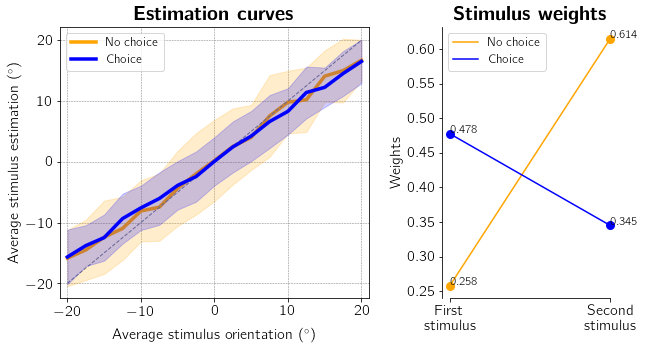

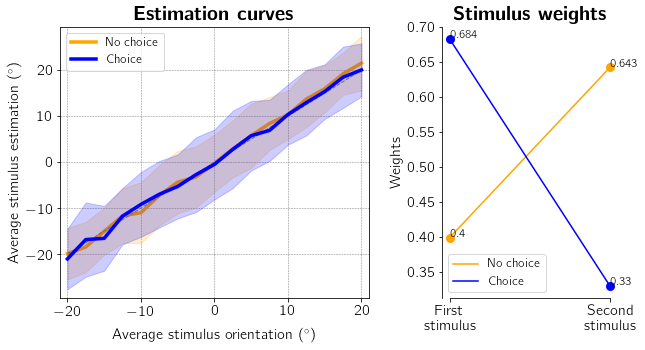

In [306]:
fig, [ax1, ax2] = plot_estimation_weights(df_002_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_002_nobump)

In [307]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./nobump_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

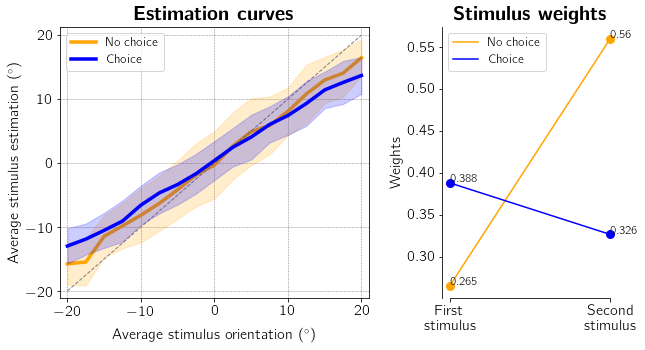

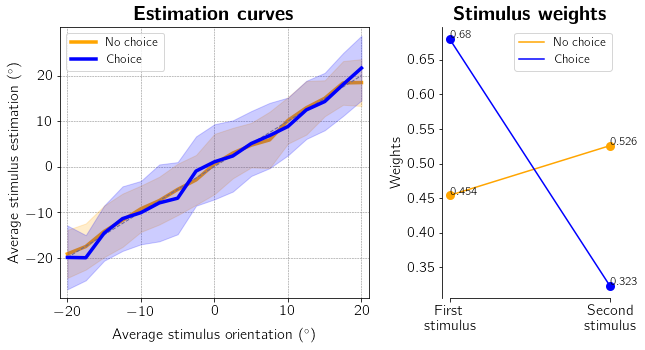

In [310]:
fig, [ax1, ax2] = plot_estimation_weights(df_005_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_005_nobump)

In [311]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./nobump_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

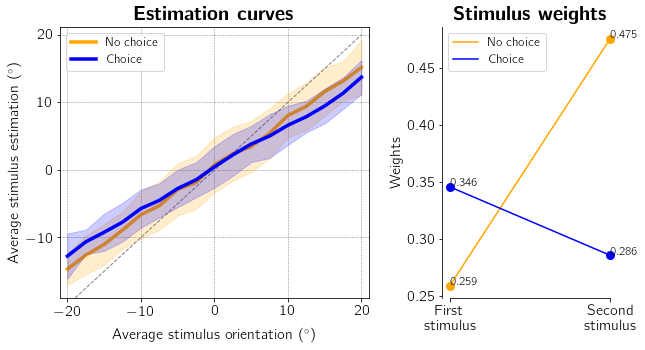

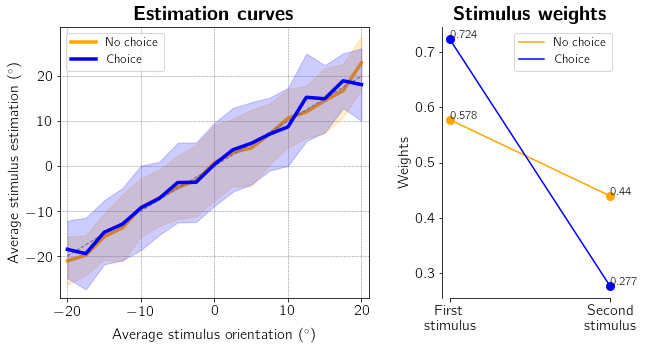

In [314]:
fig, [ax1, ax2] = plot_estimation_weights(df_010_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_010_nobump)

In [315]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_20')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

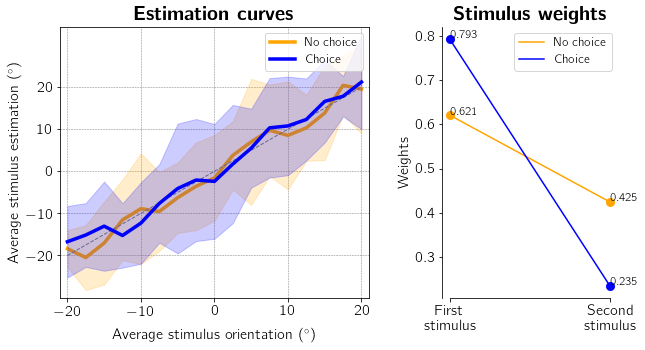

In [318]:
#fig, [ax1, ax2] = plot_estimation_weights(df_015_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_015_nobump)

#### 45 degrees

In [322]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

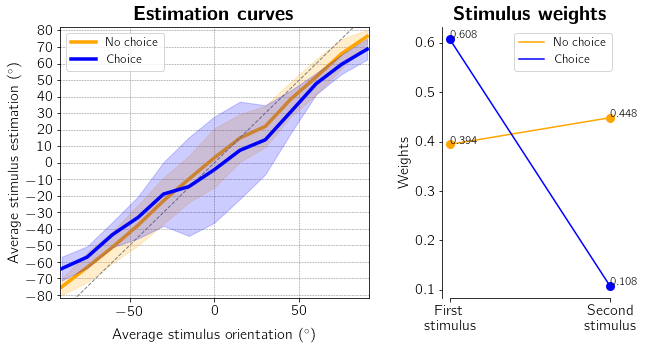

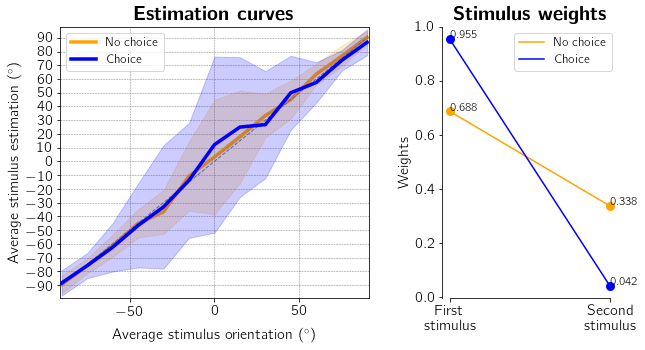

In [349]:
fig, [ax1, ax2] = plot_estimation_weights(df_002_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_002_nobump)

In [350]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

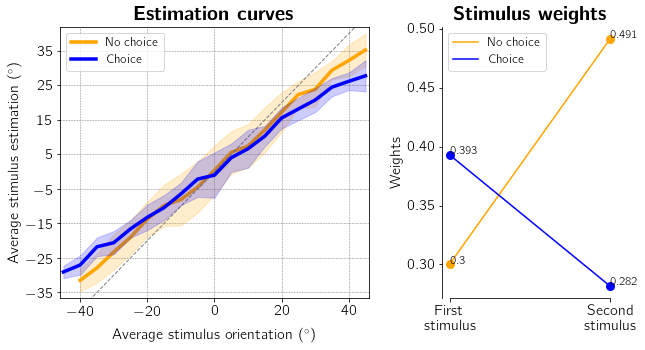

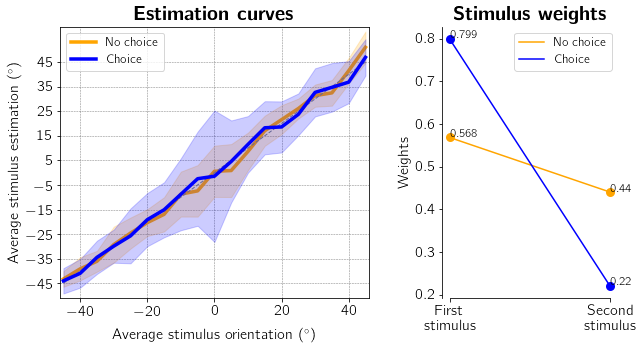

In [353]:
fig, [ax1, ax2] = plot_estimation_weights(df_005_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_005_nobump)

In [354]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

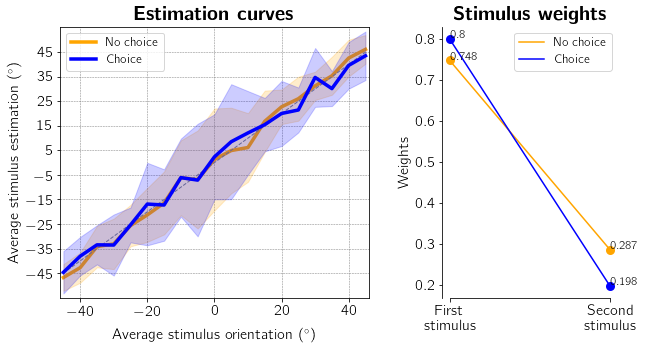

In [356]:
#fig, [ax1, ax2] = plot_estimation_weights(df_010_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_010_nobump)

In [357]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_45')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-45,45,10)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

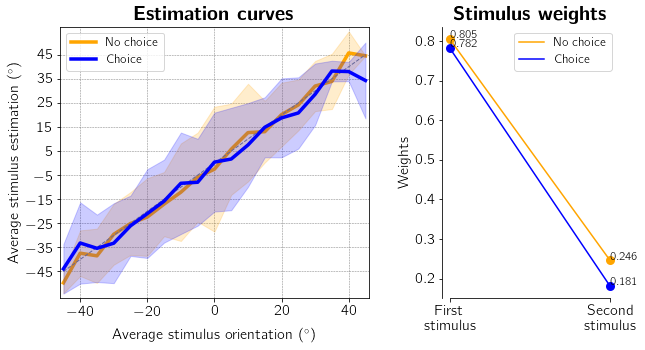

In [359]:
#fig, [ax1, ax2] = plot_estimation_weights(df_015_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_015_nobump)

#### 60 degrees

In [361]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

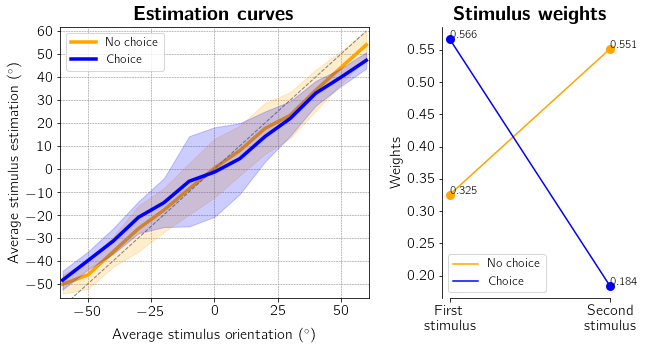

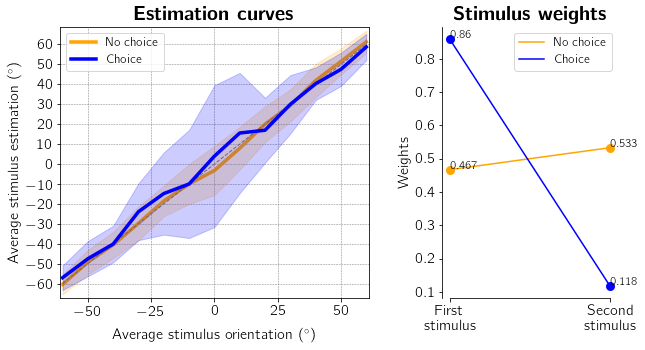

In [364]:
fig, [ax1, ax2] = plot_estimation_weights(df_002_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_002_nobump)

In [368]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

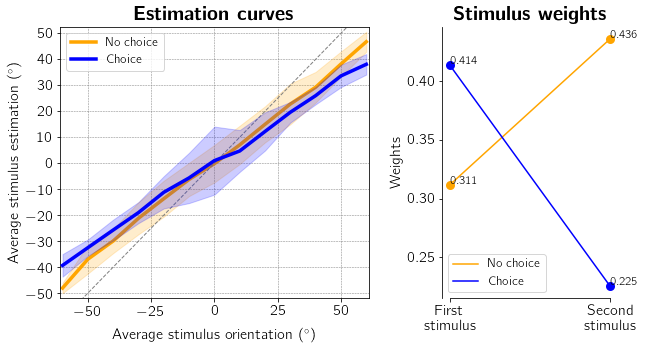

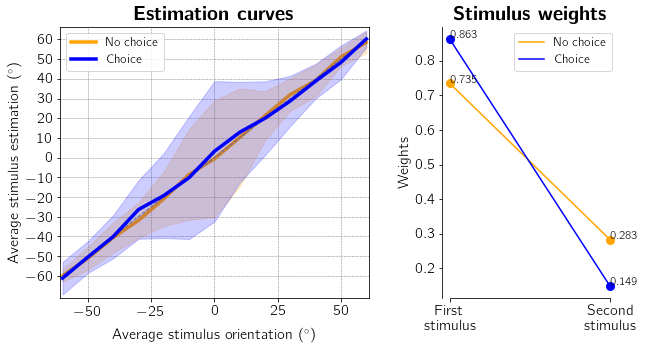

In [370]:
fig, [ax1, ax2] = plot_estimation_weights(df_005_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_005_nobump)

In [374]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

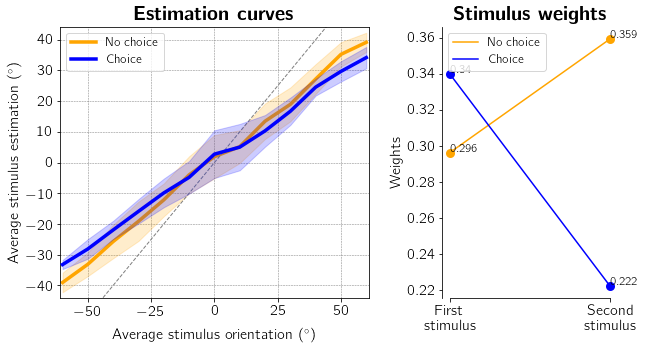

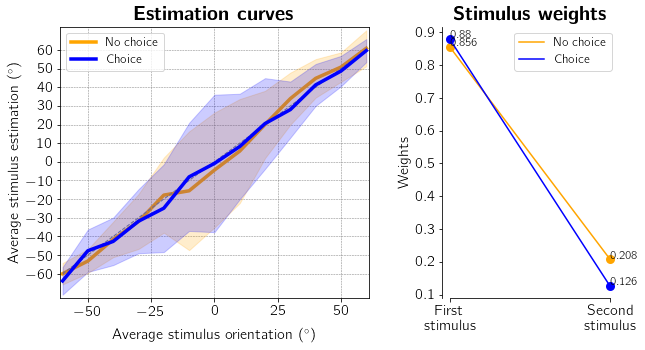

In [376]:
fig, [ax1, ax2] = plot_estimation_weights(df_010_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_010_nobump)

In [377]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_60')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-60,60,20)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

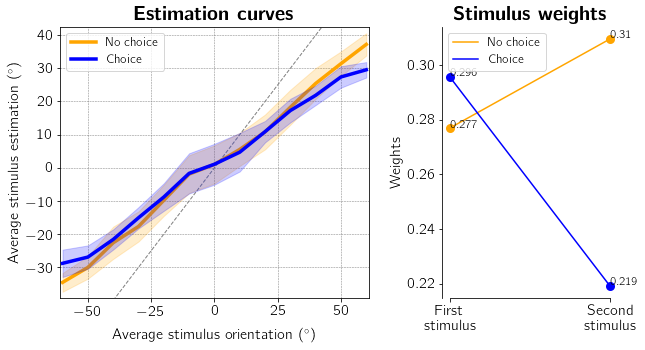

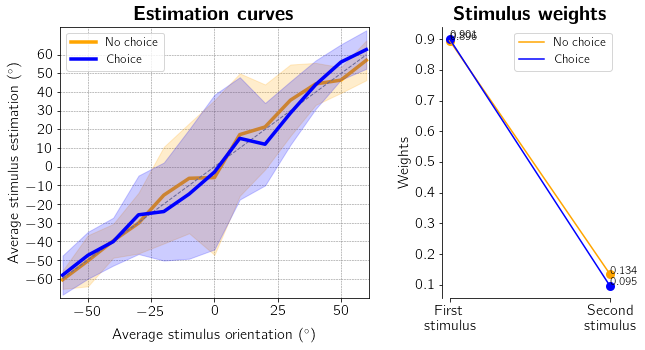

In [380]:
fig, [ax1, ax2] = plot_estimation_weights(df_015_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_015_nobump)

#### 90 degrees

In [381]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')

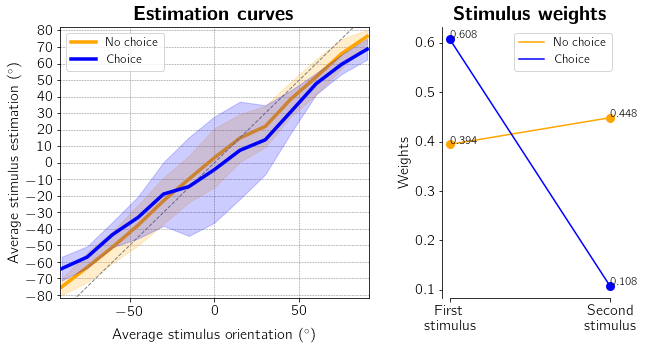

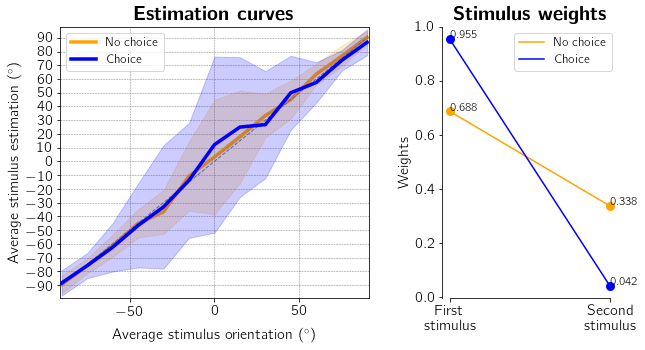

In [384]:
fig, [ax1, ax2] = plot_estimation_weights(df_002_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_002_nobump)

In [385]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

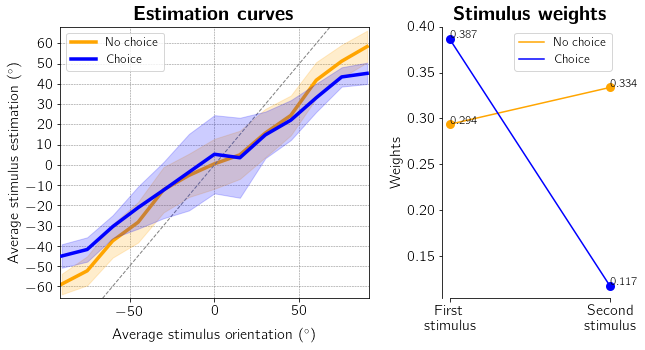

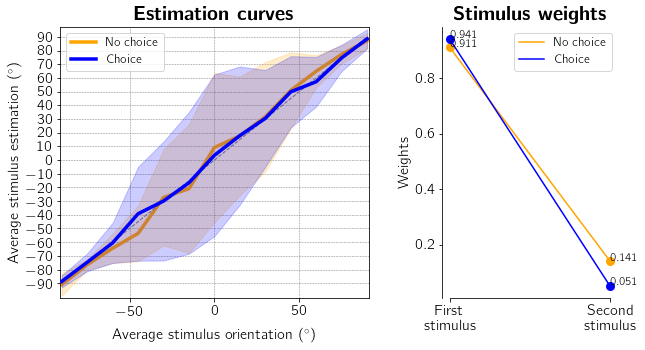

In [388]:
fig, [ax1, ax2] = plot_estimation_weights(df_005_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_005_nobump)

In [389]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')

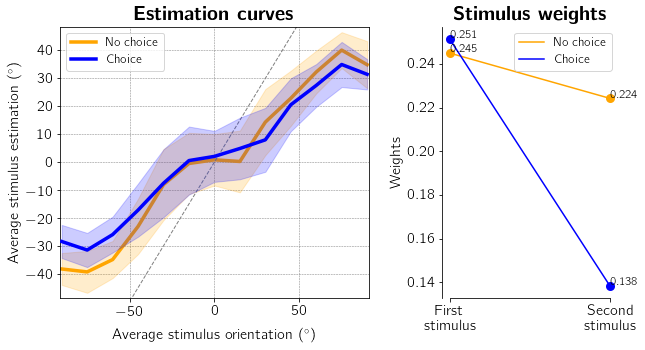

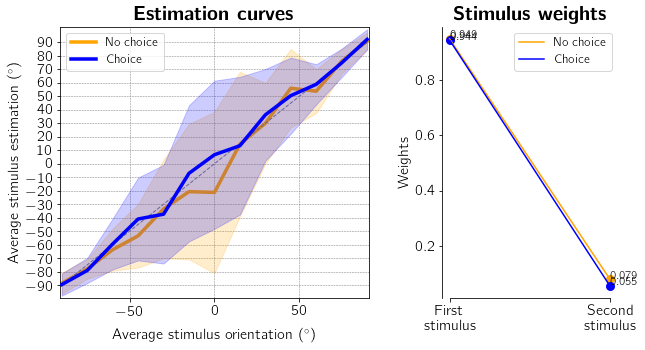

In [392]:
fig, [ax1, ax2] = plot_estimation_weights(df_010_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_010_nobump)

In [393]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/orient_90')
os.chdir('./nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump = pd.read_csv('./pdb_nobump_attention-False_ntrials-1000_oc-range(-90,90,30)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')

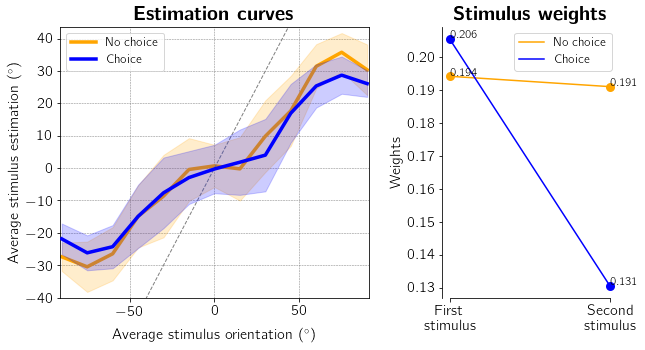

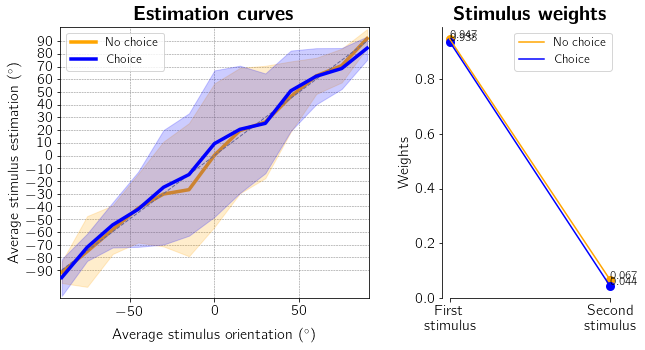

In [396]:
fig, [ax1, ax2] = plot_estimation_weights(df_015_bump)
fig, [ax1, ax2] = plot_estimation_weights(df_015_nobump)

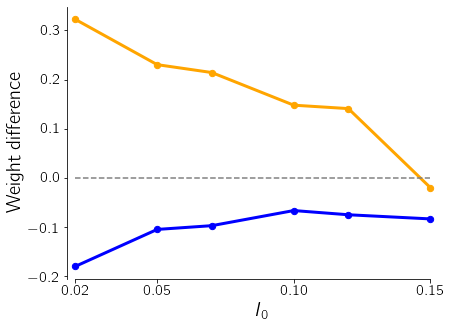

In [334]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

#ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[0], dw_005_nobump[0], dw_010_nobump[0], 
#                                                       dw_015_nobump[0]]), linestyle='dashed', lw=3, c='blue', zorder=1)
#ax1.plot(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[1], dw_005_nobump[1], dw_010_nobump[1], 
#                                                       dw_015_nobump[1]]), linestyle='dashed', lw=3, c='orange', zorder=1)
ax1.plot(np.array([0.02, 0.05, 0.07, 0.10, 0.12, 0.15]), np.array([dw_002_bump[0], dw_005_bump[0], dw_007_bump[0], dw_010_bump[0], dw_012_bump[0],
                                                       dw_015_bump[0]]), linestyle='solid', lw=3, c='blue', zorder=1)
ax1.plot(np.array([0.02, 0.05, 0.07, 0.10, 0.12, 0.15]), np.array([dw_002_bump[1], dw_005_bump[1], dw_007_bump[1], dw_010_bump[1], dw_012_bump[1],
                                                       dw_015_bump[1]]), linestyle='solid', lw=3, c='orange', zorder=1)
ax1.plot(np.linspace(0.02, 0.15, 50), np.repeat(0, 50), lw=1.5, linestyle='dashed', c='grey', zorder=1)

#ax1.scatter(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[0], dw_005_nobump[0], dw_010_nobump[0], 
#                                                       dw_015_nobump[0]]), linestyle='dashed', s=40, c='blue', facecolors='none', zorder=2)
#ax1.scatter(np.array([0.02, 0.05, 0.10, 0.15]), np.array([dw_002_nobump[1], dw_005_nobump[1], dw_010_nobump[1], 
#                                                       dw_015_nobump[1]]), linestyle='dashed', s=40, c='orange', facecolors='none', zorder=2)
ax1.scatter(np.array([0.02, 0.05, 0.07, 0.10, 0.12, 0.15]), np.array([dw_002_bump[0], dw_005_bump[0], dw_007_bump[0], dw_010_bump[0], dw_012_bump[0],
                                                          dw_015_bump[0]]), linestyle='solid', s=40, c='blue', facecolors='none', zorder=2)
ax1.scatter(np.array([0.02, 0.05, 0.07, 0.10, 0.12, 0.15]), np.array([dw_002_bump[1], dw_005_bump[1], dw_007_bump[1], dw_010_bump[1], dw_012_bump[1],
                                                          dw_015_bump[1]]), linestyle='solid', s=40, c='orange', facecolors='none', zorder=2)


ax1.set_xticks(np.array([0.02, 0.05, 0.10, 0.15]))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel('$I_0$', fontsize=20)
ax1.set_ylabel('Weight difference', fontsize=20)

#ax1.legend(['Choice. No initial bump', 'No choice. No initial bump', 'Choice. Initial Bump', 'No choice. Initial Bump'], fontsize=12.5)

ax1.set_xlim([0.017, 0.16])
ax1.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(True)
ax1.spines.left.set_visible(True)
ax1.spines.right.set_visible(False)
ax1.spines.bottom.set_bounds((0.02, 0.15))
ax1.tick_params(axis='both', which='major', labelsize=15)

#plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/weights.pdf', format='pdf')
plt.show()

In [25]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results')
os.chdir('./bump_biased_attention-False_ntrials-100_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-100_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_ic_005_bump = np.load('./r_ic_bump_biased_attention-False_ntrials-100_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

In [27]:
df_005_bump.loc[df_005_bump.x2 == 90]

Trial  index  x1i   x2i   x1    x2  average  bincorrect  do_choice  \
33     33     33  9.0  18.0  0.0  90.0     45.0         1.0        0.0   
39     39     39  9.0  18.0  0.0  90.0     45.0         1.0        1.0   
47     47     47  9.0  18.0  0.0  90.0     45.0         1.0        1.0   
71     71     71  9.0  18.0  0.0  90.0     45.0         1.0        1.0   

    category  subj  init_ph_n      estim  binchoice   binrt       ph1  \
33      45.0   1.0        1.0  50.041800        1.0 -1.0000  1.758391   
39      45.0   1.0        1.0  17.231885        1.0  0.2696  1.892628   
47      45.0   1.0        1.0  10.082914        1.0  0.3312 -1.433115   
71      45.0   1.0        1.0  13.063479        1.0  0.3140 -1.036229   

          ph2       phd    ph_last  chosen  
33  50.041800  1.494266  52.358905      33  
39  17.231885  1.599171  17.917100      39  
47  10.082914 -1.220060  10.770423      47  
71  13.063479 -1.053574  13.714911      71

Do choice? True


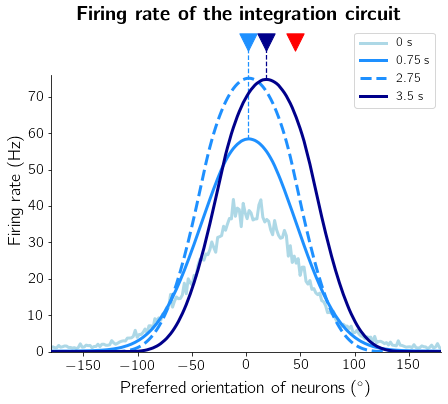

In [31]:
ntrial = 39
fig, [ax1] = plot_bump_ic(df_005_bump, r_ic_005_bump, ntrial=ntrial)

In [52]:
df_005_bump_att

Trial  index  x1i  x2i    x1    x2  average  bincorrect  do_choice  \
0       0      0  0.0  0.0 -20.0 -20.0    -20.0         0.0        0.0   
1       1      1  7.0  3.0  15.0  -5.0      5.0         1.0        1.0   
2       2      2  6.0  5.0  10.0   5.0      7.5         1.0        0.0   
3       3      3  1.0  2.0 -15.0 -10.0    -12.5         0.0        1.0   
4       4      4  5.0  0.0   5.0 -20.0     -7.5         1.0        1.0   
..    ...    ...  ...  ...   ...   ...      ...         ...        ...   
95     95     95  6.0  3.0  10.0  -5.0      2.5         1.0        0.0   
96     96     96  7.0  5.0  15.0   5.0     10.0         1.0        1.0   
97     97     97  3.0  1.0  -5.0 -15.0    -10.0         0.0        1.0   
98     98     98  2.0  0.0 -10.0 -20.0    -15.0         0.0        0.0   
99     99     99  8.0  5.0  20.0   5.0     12.5         1.0        0.0   

    category  subj  init_ph_n      estim  binchoice   binrt        ph1  \
0      -20.0   1.0        1.0 -13.108696       -1.0 -1.0000 -17.188050   
1        5.0   1.0        1.0   6.619149        1.0  0.2974  11.258595   
2        7.5   1.0        1.0   6.294055        1.0 -1.0000   3.877294   
3      -12.5   1.0        1.0 -13.293227       -1.0  0.3546  -8.109340   
4       -7.5   1.0        1.0  -2.956917        1.0  0.4528   0.892179   
..       ...   ...        ...        ...        ...     ...        ...   
95       2.5   1.0        1.0  -4.079570        1.0 -1.0000   6.160962   
96      10.0   1.0        1.0   9.460477        1.0  0.2914  11.432998   
97     -10.0   1.0        1.0 -14.648583       -1.0  0.5022  -2.515397   
98     -15.0   1.0        1.0 -15.873290       -1.0 -1.0000  -5.623176   
99      12.5   1.0        1.0   6.896113        1.0 -1.0000  14.131946   

          ph2        phd    ph_last  chosen  
0  -13.108696 -17.426074 -13.555877       0  
1    6.619149  12.156950   6.566892       1  
2    6.294055   4.318588   6.436957       2  
3  -13.293227  -9.335067 -13.678550       3  
4   -2.956917   1.732362  -3.044153       4  
..        ...        ...        ...     ...  
95  -4.079570   6.530121  -4.085704      95  
96   9.460477  12.303708   9.715692      96  
97 -14.648583  -3.514364 -15.124337      97  
98 -15.873290  -5.725706 -15.960511      98  
99   6.896113  14.442831   6.545500      99  

[100 rows x 20 columns]

In [22]:
def plot_rdc_lri(data, r_dc, lri, idx_nochoice, idx_choice, save=False):
    
    d1, d2 = r_dc[:, 0, :], r_dc[:, 1, :]
    li, ri = lri[:, 0, :], lri[:, 1, :]
    
    fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(16, 6), gridspec_kw={'height_ratios': [.125, 1.], 'width_ratios': [1., 1.]}, sharex=True, sharey=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.05)
    plt.suptitle('\\textbf{Activity of the decision circuit}', y=0.95, fontsize=25)

    min_dc_nochoice = min(np.min(d1[:-1, idx_nochoice]), np.min(d2[:-1, idx_nochoice]))
    max_dc_nochoice = max(np.max(d1[:-1, idx_nochoice]), np.max(d2[:-1, idx_nochoice]))
    
    min_dc_choice = min(np.min(d1[:-1, idx_choice]), np.min(d2[:-1, idx_choice]))
    max_dc_choice = max(np.max(d1[:-1, idx_choice]), np.max(d2[:-1, idx_choice]))
    
    min_lri_nochoice = min(np.min(li[:-1, idx_nochoice]), np.min(ri[:-1, idx_nochoice]))
    max_lri_nochoice = max(np.max(li[:-1, idx_nochoice]), np.max(ri[:-1, idx_nochoice]))
    
    min_lri_choice = min(np.min(li[:-1, idx_choice]), np.min(ri[:-1, idx_choice]))
    max_lri_choice = max(np.max(li[:-1, idx_choice]), np.max(ri[:-1, idx_choice]))
    
    ax1.fill_between(np.linspace(0, 0.75, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(0.76, 1.75, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(1.76, 2.75, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax1.fill_between(np.linspace(2.76, 3.6, 10), max_dc_choice + 0.5, max_dc_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    ax1.annotate('First\n stimulus', (0.125, max_dc_choice + 0.65), fontsize=15, zorder=2) 
    ax1.annotate('Decision period', (0.785, max_dc_choice + 1.3), fontsize=15, zorder=2) 
    ax1.annotate('Delay', (2.1, max_dc_choice + 1.3), fontsize=15, zorder=2) 
    ax1.annotate('Second\n stimulus', (2.9, max_dc_choice + 0.65), fontsize=15, zorder=2) 

    ax1.set_axis_off()
    ax1.spines.top.set_visible(False)
    ax1.spines.bottom.set_visible(False)
    ax1.spines.left.set_visible(False)
    ax1.spines.right.set_visible(False)
    
    ax3.fill_between(np.linspace(0, 0.75, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    ax3.fill_between(np.linspace(0.76, 1.75, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax3.fill_between(np.linspace(1.76, 2.75, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax3.fill_between(np.linspace(2.76, 3.6, 10), max_lri_choice + 0.5, max_lri_choice + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    #ax3.fill_between(np.linspace(0, 0.75, 10), max_rgs + 0.5, max_rgs + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')
    #ax3.fill_between(np.linspace(0.76, 1.75, 10), max_rgs + 0.5, max_rgs + 3, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    #ax3.fill_between(np.linspace(1.76, 2.75, 10), max_rgs + 0.5, max_rgs + 3, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    #ax3.fill_between(np.linspace(2.76, 3.6, 10), max_rgs + 0.5, max_rgs + 3, color='black', alpha=0.1, zorder=1, label='_nolegend_')

    ax3.annotate('First\n stimulus', (0.125, max_lri_choice + 0.65), fontsize=15, zorder=2) 
    ax3.annotate('Decision period', (0.785, max_lri_choice + 1.3), fontsize=15, zorder=2) 
    ax3.annotate('Delay', (2.1, max_lri_choice + 1.3), fontsize=15, zorder=2) 
    ax3.annotate('Second\n stimulus', (2.9, max_lri_choice + 0.65), fontsize=15, zorder=2) 

    ax3.set_axis_off()
    ax3.spines.top.set_visible(False)
    ax3.spines.bottom.set_visible(False)
    ax3.spines.left.set_visible(False)
    ax3.spines.right.set_visible(False)

    ax2.plot(np.linspace(0, 3.6, d1.shape[0]-1), d1[:-1, idx_nochoice], lw=3, linestyle='dashed', c='blue', zorder=1)
    ax2.plot(np.linspace(0, 3.6, d1.shape[0]-1), d2[:-1, idx_nochoice], lw=3, linestyle='dashed', c='orange', zorder=1)

    ax5 = ax2.twinx()
    ax5.plot(np.linspace(0, 3.6, d1.shape[0]-1), d1[:-1, idx_choice], lw=3, linestyle='solid', c='blue', zorder=2)
    ax5.plot(np.linspace(0, 3.6, d1.shape[0]-1), d2[:-1, idx_choice], lw=3, linestyle='solid', c='orange', zorder=2)
    
    ax4.plot(np.linspace(0, 3.6, li.shape[0]-1), li[:-1, idx_nochoice], lw=3, linestyle='dashed', c='blue')
    ax4.plot(np.linspace(0, 3.6, ri.shape[0]-1), ri[:-1, idx_nochoice], lw=3, linestyle='dashed', c='orange')
    
    ax6 = ax4.twinx()
    ax6.plot(np.linspace(0, 3.6, li.shape[0]-1), li[:-1, idx_choice], lw=3, linestyle='solid', c='blue')
    ax6.plot(np.linspace(0, 3.6, ri.shape[0]-1), ri[:-1, idx_choice], lw=3, linestyle='solid', c='orange')
        
    ax5.fill_between(np.linspace(0, 0.75, 10), min_dc_choice, max_dc_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    ax5.fill_between(np.linspace(0.76, 1.75, 10), min_dc_choice, max_dc_choice, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax5.fill_between(np.linspace(1.76, 2.75, 10), min_dc_choice, max_dc_choice, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax5.fill_between(np.linspace(2.76, 3.6, 10), min_dc_choice, max_dc_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    
    ax6.fill_between(np.linspace(0, 0.75, 10), min_lri_choice, max_lri_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    ax6.fill_between(np.linspace(0.76, 1.75, 10), min_lri_choice, max_lri_choice, color='orange', alpha=0.25, zorder=1, label='_nolegend_')
    ax6.fill_between(np.linspace(1.76, 2.75, 10), min_lri_choice, max_lri_choice, color='orange', alpha=0.15, zorder=1, label='_nolegend_')
    ax6.fill_between(np.linspace(2.76, 3.6, 10), min_lri_choice, max_lri_choice, color='black', alpha=0.05, zorder=1, label='_nolegend_')
    
    ax2.tick_params(axis='both', which='major', labelsize=15)
    ax2.set_xlabel('Time (s)', fontsize=15)
    ax2.set_ylabel('Firing rate for no-choice trials (Hz)', fontsize=15)
    ax2.set_xlim([-0.025, 3.625])
    ax2.set_ylim([min(np.min(d1[:-1, idx_nochoice]), np.min(d2[:-1, idx_nochoice])), max(np.max(d1[:-1, idx_nochoice]), np.max(d2[:-1, idx_nochoice])) + 1])
    
    ax5.set_xlim([-0.025, 3.625])
    ax5.set_ylim([min(np.min(d1[:-1, idx_choice]), np.min(d2[:-1, idx_choice])) - 1, max(np.max(d1[:-1, idx_choice]), np.max(d2[:-1, idx_choice])) + 1])
    ax5.tick_params(axis='both', which='major', labelsize=15)
    ax5.set_ylabel('Firing rate for choice trials (Hz)', fontsize=15)
    
    ax4.tick_params(axis='both', which='major', labelsize=15)
    ax4.set_xlabel('Time (s)', fontsize=15)
    ax4.set_ylabel('Left and right input for no-choice trials', fontsize=15)
    ax4.set_xlim([-0.025, 3.625])    
    ax4.set_ylim([min_lri_nochoice - 0.0006, max_lri_nochoice + 0.0006])
    
    ax6.set_xlim([-0.025, 3.625])
    ax6.tick_params(axis='both', which='major', labelsize=15)
    ax6.set_xlim([-0.025, 3.625]) 
    ax6.set_ylim([min_lri_choice - 0.0006, max_lri_choice + 0.0006])
    ax6.set_ylabel('Left and right input for choice trials', fontsize=15)

    return fig, [ax1, ax2, ax3, ax4, ax5]

In [23]:
import os 
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump_noatt = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_dc_005_nobump_noatt = np.load('./r_dc_bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_005_nobump_noatt = np.load('./r_ic_bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
lri_005_nobump_noatt = np.load('./lri_bump_biased_attention-False_ntrials-300_oc-range(-90,90,10)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

(<Figure size 1152x432 with 6 Axes>,
 [<AxesSubplot: >,
  <AxesSubplot: xlabel='Time (s)', ylabel='Firing rate for no-choice trials (Hz)'>,
  <AxesSubplot: >,
  <AxesSubplot: xlabel='Time (s)', ylabel='Left and right input for no-choice trials'>,
  <AxesSubplot: ylabel='Firing rate for choice trials (Hz)'>])

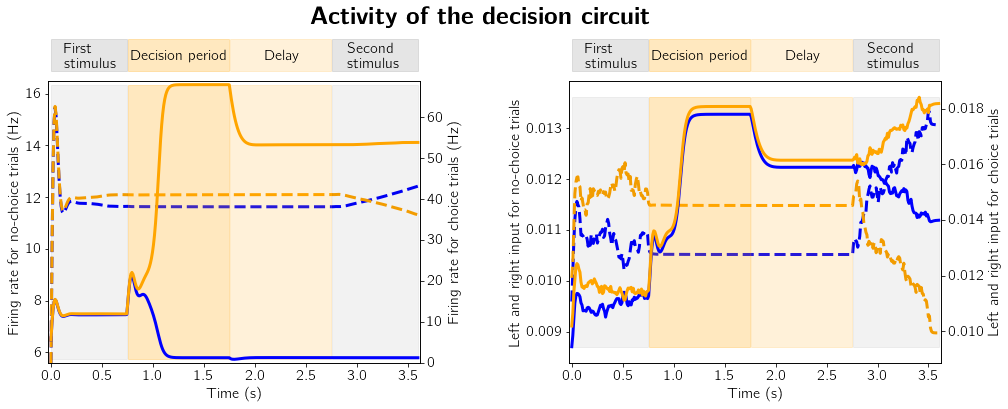

In [25]:
plot_rdc_lri(df_005_nobump_noatt, r_dc_005_nobump_noatt, lri_005_nobump_noatt, idx_nochoice=20, idx_choice=0, save=False)

#### Confirmation bias

In [ ]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/bump_biased_attention-False_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump_noatt = pd.read_csv('./pdb_bump_biased_attention-False_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_dc_005_nobump_noatt = np.load('./r_dc_bump_biased_attention-False_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_005_nobump_noatt = np.load('./r_ic_bump_biased_attention-False_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_005_nobump_noatt = np.load('./r_sc_bump_biased_attention-False_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/bump_biased_attention-True_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump_att = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_dc_005_nobump_att = np.load('./r_dc_bump_biased_attention-True_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_005_nobump_att = np.load('./r_ic_bump_biased_attention-True_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_005_nobump_att = np.load('./r_sc_bump_biased_attention-True_ntrials-360_oc-range(-180,180,1)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

th = np.linspace(-180, 180, 200)

ax1.plot(th, r_sc_005_nobump_att[348, 90, :200], zorder=1, lw=3, c='black')
ax1.plot(th, r_sc_005_nobump_noatt[348, 90, :200], zorder=2, lw=3, c='dodgerblue')
ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)
ax1.set_title('\\textbf{Stimulus at $-90^\circ$ and attention signal at $90^\circ$}', fontsize=17.5)

ax2.plot(th, r_sc_005_nobump_att[348, 270, :200], zorder=1, lw=3, c='black')
ax2.plot(th, r_sc_005_nobump_noatt[348, 270, :200], zorder=2, lw=3, c='dodgerblue')
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)
ax2.set_title('\\textbf{Stimulus at $90^\circ$ and attention signal at $90^\circ$}', fontsize=17.5)

#ax3.plot(th, att_005_nobump_att[330, 270, :200], zorder=1)
#ax3.plot(th, att_005_nobump_att[330, 270, 200:], zorder=2)
ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)
ax3.set_title('\\textbf{Attention signal to excitatory and inhibitory neurons}', fontsize=17.5)

fig.tight_layout()
plt.show()

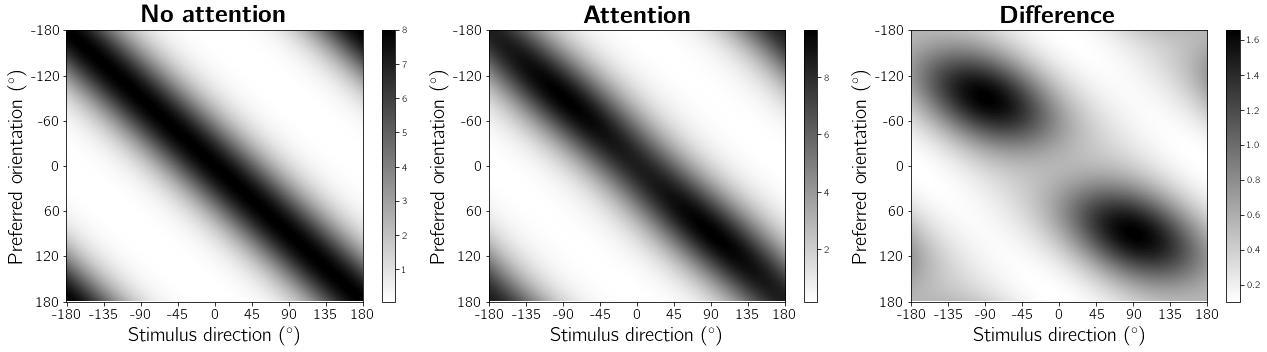

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

im1 = ax1.imshow(r_sc_005_nobump_noatt[350, :, :200].T, cmap='gray_r', aspect='auto')
ax1.set_xlabel('Stimulus direction $(^\circ)$', fontsize=20)
ax1.set_ylabel('Preferred orientation $(^\circ)$', fontsize=20)
ax1.set_title('\\textbf{No attention}', fontsize=25)
fig.colorbar(im1, orientation='vertical')

ax1.set_xticks(np.linspace(0, 360, 9))
ax1.set_xticklabels(np.linspace(-180, 180, 9, dtype='int'))
ax1.set_yticks(np.linspace(0, 200, 7))
ax1.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

im2 = ax2.imshow(r_sc_005_nobump_att[350, :, :200].T, cmap='gray_r', aspect='auto')
ax2.set_xlabel('Stimulus direction $(^\circ)$', fontsize=20)
ax2.set_ylabel('Preferred orientation $(^\circ)$', fontsize=20)
ax2.set_title('\\textbf{Attention}', fontsize=25)
fig.colorbar(im2, orientation='vertical')

ax2.set_xticks(np.linspace(0, 360, 9))
ax2.set_xticklabels(np.linspace(-180, 180, 9, dtype='int'))
ax2.set_yticks(np.linspace(0, 200, 7))
ax2.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

im3 = ax3.imshow(r_sc_005_nobump_att[350, :, :200].T - r_sc_005_nobump_noatt[350, :, :200].T, cmap='gray_r', aspect='auto')
ax3.set_xlabel('Stimulus direction $(^\circ)$', fontsize=20)
ax3.set_ylabel('Preferred orientation $(^\circ)$', fontsize=20)
ax3.set_title('\\textbf{Difference}', fontsize=25)
fig.colorbar(im3, orientation='vertical')

ax3.set_xticks(np.linspace(0, 360, 9))
ax3.set_xticklabels(np.linspace(-180, 180, 9, dtype='int'))
ax3.set_yticks(np.linspace(0, 200, 7))
ax3.set_yticklabels(np.linspace(-180, 180, 7, dtype='int'))

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
plt.show()

In [53]:
def compute_weights_consistent(data):
    """Compute stimulus weights 
    
    :param pd.DataFrame data: dataframe containing the simulation results.
    :return: the weights of the different stimulus, their standard errors and their differences for choice and no-choice trials, respectively
    :rtype: (list of float, list of float, list of float)
    """
    consistent = data.loc[np.where((np.sign(data.binchoice) == np.sign(data.x2)) & (data.do_choice == 1))]
    inconsistent = data.loc[np.where((np.sign(data.binchoice) != np.sign(data.x2)) & (data.do_choice == 1))]
    labels = re.findall(r'x[0-9]+\b', '|'.join(data.columns))
    w, wse, dw = [], [], []

    for data in [consistent, inconsistent]:
        x, y = np.array(data[labels].astype(float)), np.array(data['estim'].astype(float))
        
        # Ordinary Least Squares
        res = sm.OLS(y, x).fit()
        w.append(res.params)
        wse.append(res.bse) # standard error of the parameters estimates
        dw.append(np.diff(res.params))  # difference between weights of stimulus

    return w, wse, dw

def plot_estimation_weights_consistent(data_est, data_w, save=False):
    """ Plotting of the estimation curves and the weights on the estimation of the different stimulus

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool save: whether to save the graphics or not
    :return: the estimation curves as a function of the first stimulus and the weights of the different stimulus
    :rtype: 
    """
    
    data_cw = data_est.loc[data_est.binchoice == 1]
    data_ccw = data_est.loc[data_est.binchoice == -1]

    # for the estimation curves
    avg = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(np.mean).index.values
    est = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    # computation of the weights of the stimulus
    w, we, _ = compute_weights_consistent(data_w)
    w_cons, w_incons = np.array([w[0][0], w[0][1]]), np.array([w[1][0], w[1][1]])
    we_cons, we_incons = np.array([we[0][0], we[0][1]]), np.array([we[1][0], we[1][1]])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.75, 1]})
        
    ax1.plot(avg, est, c='steelblue', alpha=0.5, lw=2.5, linestyle='dashed', zorder=5, label='_nolegend_')
    ax1.plot(np.linspace(np.min(avg), np.max(avg), 100), np.linspace(np.min(avg), np.max(avg), 100),
             '--', alpha=0.75, c='black', lw=1.5, label='_nolegend_')
    
    ax1.plot(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)], c='red', linestyle='dashed', alpha=1, lw=3, zorder=5)
    ax1.fill_between(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)] - std_cw[np.where(avg_cw < 0)], 
                     est_cw[np.where(avg_cw < 0)] + std_cw[np.where(avg_cw < 0)], color='red', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax1.plot(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)], c='red', linestyle='solid', alpha=1, lw=3, zorder=5)
    ax1.fill_between(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)], 
                     est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], color='red', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax1.scatter(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)], c='red', s=50, zorder=5)
    ax1.scatter(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)], c='red', s=50, zorder=5)
    
    ax1.grid(color = 'grey', linestyle = 'dashed', linewidth = 0.5)
    
    #ax1.set_yticks(np.arange(np.min(data.x2), np.max(data.x2), 20))
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.set_xlabel('Average stimulus orientation $(^\circ)$', fontsize=15)
    ax1.set_ylabel('Average stimulus estimation $(^\circ)$', fontsize=15)

    ax1.set_title('\\textbf{Estimation curves}', fontsize=20)
    ax1.legend(['CW inconsistent', 'CW consistent'], fontsize=12.5, loc='upper left')
    ax1.set_xlim([np.min(data_est.average) - 0.5, np.max(data_est.average) + 0.5])
    ax1.set_ylim([np.min([np.concatenate([est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], 
                                          est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)]])]),   
                  np.max([np.concatenate([est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], 
                                          est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)]])])]) 
    
    ax3 = ax1.twinx().twiny()  # instantiate a second axes that shares the same x-axis
    
    ax3.plot(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)], c='blue', linestyle='solid', alpha=1, lw=3, zorder=5)
    ax3.fill_between(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)], 
                     est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], color='blue', alpha=0.2, label='_nolegend_', zorder=3)

    ax3.plot(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)], c='blue', linestyle='dashed', alpha=1, lw=3, zorder=5)
    ax3.fill_between(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)] - std_ccw[np.where(avg_ccw > 0)], 
                     est_ccw[np.where(avg_ccw > 0)] + std_ccw[np.where(avg_ccw > 0)], color='blue', alpha=0.2, label='_nolegend_', zorder=3)
    ax3.scatter(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)], c='blue', s=50, zorder=5)
    ax3.scatter(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)], c='blue', s=50, zorder=5)

    ax3.set_xlim([np.min(data_est.average) - 0.5, np.max(data_est.average) + 0.5])
    ax3.set_ylim([np.min([np.concatenate([est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], 
                                          est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)]])]),   
                  np.max([np.concatenate([est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], 
                                          est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)]])])]) 
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.legend(['CCW consistent', 'CCW inconsistent'], fontsize=12.5, loc='lower right')
    
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_cons, lw=1.5, c='orange')
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_incons, lw=1.5, c='blue')

    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_cons, lw=3, c='orange')
    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_incons, lw=3, c='blue')

    ax2.annotate(w_cons[0].round(3), (0, w_cons[0]), fontsize=12) 
    ax2.annotate(w_incons[0].round(3), (0, w_incons[0]), fontsize=12) 
    ax2.annotate(w_cons[1].round(3), (1, w_cons[1]), fontsize=12) 
    ax2.annotate(w_incons[1].round(3), (1, w_incons[1]), fontsize=12) 

    ax2.spines.top.set_visible(False)
    ax2.spines.bottom.set_visible(True)
    ax2.spines.left.set_visible(True)
    ax2.spines.right.set_visible(False)
    ax2.spines.bottom.set_bounds((0, 1))
    ax2.tick_params(axis='both', which='major', labelsize=15)

    ax2.set_title('\\textbf{Stimulus weights}', fontsize=20)
    ax2.legend(['Consistent', 'Inconsistent'], fontsize=12.5)
        
    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/est_consistent_i0-0.05_bump_biased.pdf', 
                    format='pdf', transparent=True)

    return fig, [ax1, ax2]

In [15]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_bump_att_est = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')
df_002_bump_att_w = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.02_frames-2_t-3.6_01.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump_att_est = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
df_005_bump_att_w = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.05_frames-2_t-3.6_01.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_bump_att_est = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')
df_010_bump_att_w = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.10_frames-2_t-3.6_01.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_bump_att_est = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')
df_015_bump_att_w = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.15_frames-2_t-3.6_01.csv')

[array([0.30949711, 0.53209417, 1.3458505 ]), array([0.3760933 , 0.24026369, 2.27817276]), array([ 0.23806444,  0.40316868, -4.21481201]), array([ 0.34007708,  0.26392356, -2.64959972])]


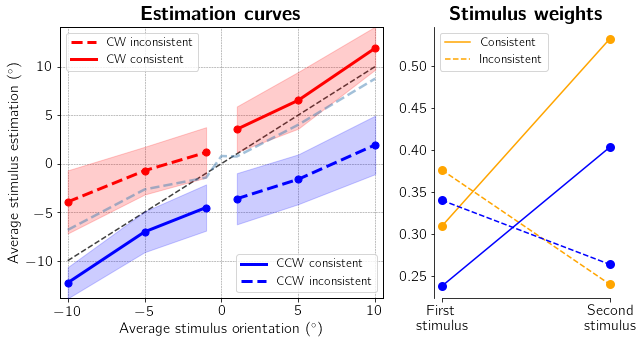

In [160]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_002_bump_att_est, df_002_bump_att_w, save=True)

[array([0.29089405, 0.47655795, 1.85689368]), array([0.36718113, 0.23039696, 1.62734897]), array([ 0.21402015,  0.43849661, -2.98417277]), array([ 0.3047471 ,  0.28326661, -2.54679543])]


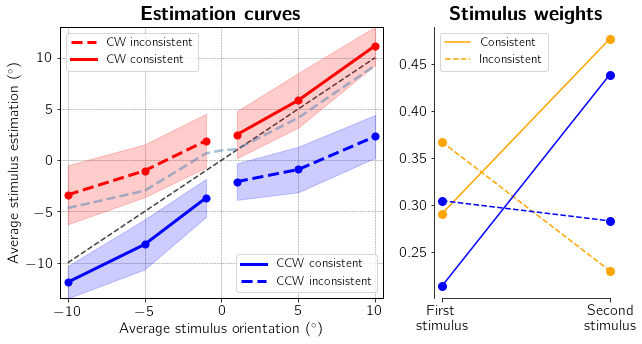

In [161]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_005_bump_att_est, df_005_bump_att_w, save=True)

[array([0.27191884, 0.39127926, 1.96789626]), array([0.32992148, 0.21130146, 1.18654312]), array([ 0.26165111,  0.40269084, -1.51734308]), array([ 0.30405309,  0.23419425, -1.25052935])]


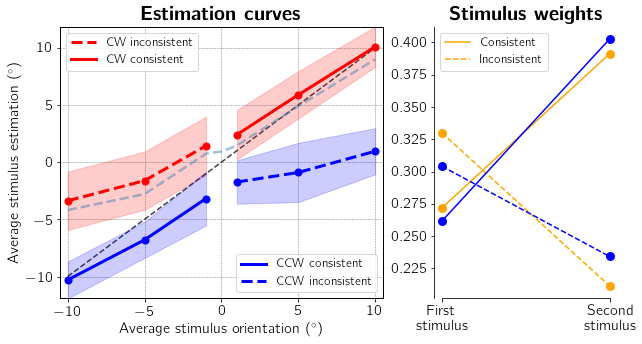

In [162]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_010_bump_att_est, df_010_bump_att_w, save=True)

[array([0.26006769, 0.45499301, 1.03949297]), array([0.32137759, 0.20968246, 1.19763892]), array([ 0.22670683,  0.29087924, -2.6583872 ]), array([ 0.30625589,  0.23037026, -1.20461243])]


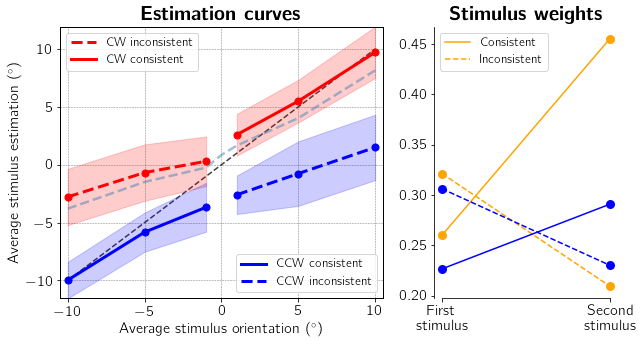

In [163]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_015_bump_att_est, df_015_bump_att_w, save=True)

In [23]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump_att_est = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')
df_002_nobump_att_w = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.02_frames-2_t-3.6_01.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump_att_est = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
df_005_nobump_att_w = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.05_frames-2_t-3.6_01.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump_att_est = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')
df_010_nobump_att_w = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.10_frames-2_t-3.6_01.csv')

os.chdir('/Users/miguel/Desktop/post_choice_bias/results/regimes_bump_attention')
os.chdir('./nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump_att_est = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')
#df_015_nobump_att_w = pd.read_csv('./pdb_nobump_attention-True_ntrials-500_oc-range(-20,20,4)_sigma-0.15_i0-0.15_frames-2_t-3.6_01.csv')

[array([0.30845697, 0.51378343, 3.27326824]), array([0.510715  , 0.18840365, 3.45969056]), array([ 0.32095481,  0.3647549 , -5.96090469]), array([ 0.41418457,  0.28296483, -5.57389914])]


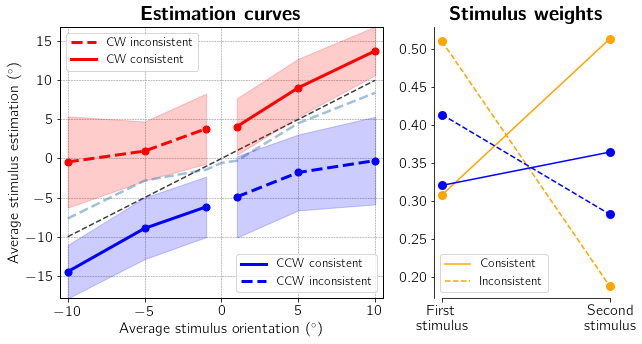

In [164]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_002_nobump_att_est, df_002_nobump_att_w, save=True)

[array([0.32401812, 0.37787082, 5.758674  ]), array([0.43980027, 0.07028497, 2.24331789]), array([ 0.32960922,  0.40633557, -5.48081321]), array([ 0.47021956,  0.15035474, -4.58172754])]


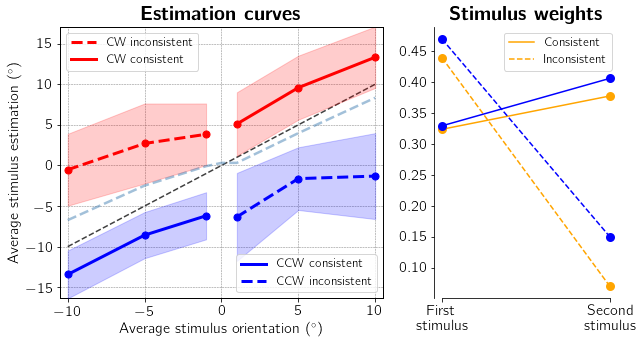

In [165]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_005_nobump_att_est, df_005_nobump_att_w, save=True)

[array([0.32624742, 0.38163425, 6.08984727]), array([0.49471452, 0.25533222, 5.60002634]), array([ 0.37608509,  0.32913978, -5.84970775]), array([ 0.47530848,  0.29450481, -6.61200815])]


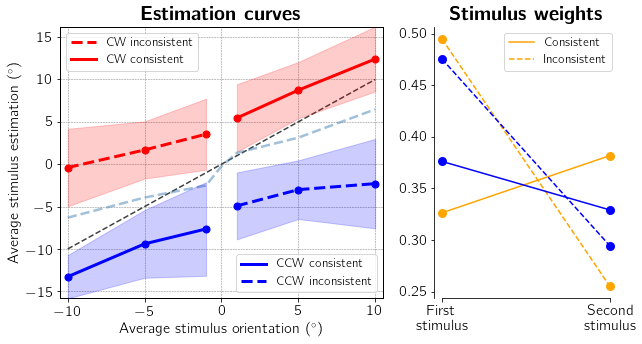

In [166]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_010_nobump_att_est, df_010_nobump_att_w, save=True)

[array([0.28991564, 0.60793782, 6.59260447]), array([ 0.40469517, -0.27770079,  5.43871714]), array([  0.29638365,   0.14070337, -11.2006087 ]), array([  0.48709852,   0.27445472, -11.6556897 ])]


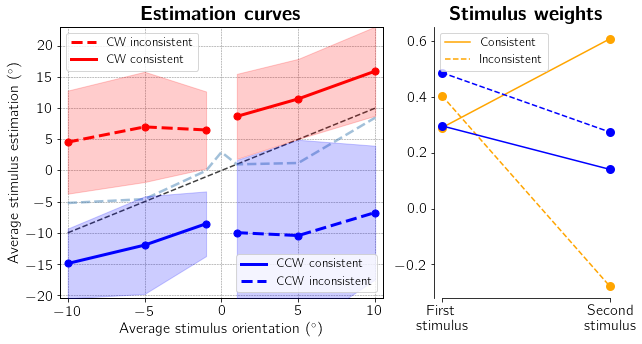

In [167]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_015_nobump_att_est, df_015_nobump_att_w, save=True)

#### Changing the estimation curves and the weights plot

In [10]:
def plot_estimation_weights_consistent(data_est, data_w, save=False):
    """ Plotting of the estimation curves and the weights on the estimation of the different stimulus

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool save: whether to save the graphics or not
    :return: the estimation curves as a function of the first stimulus and the weights of the different stimulus
    :rtype: 
    """
    
    data_cw = data_est.loc[data_est.binchoice > 0]
    data_ccw = data_est.loc[data_est.binchoice < 0]

    # for the estimation curves
    avg = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    # computation of the weights of the stimulus
    w, we, _ = compute_weights_consistent(data_w)
    w_cw_cons, w_cw_incons = np.array([w[0][0], w[0][1]]), np.array([w[1][0], w[1][1]])
    w_ccw_cons, w_ccw_incons = np.array([w[2][0], w[2][1]]), np.array([w[3][0], w[3][1]])
    we_cw_cons, we_cw_incons = np.array([we[0][0], we[0][1]]), np.array([we[1][0], we[1][1]])
    we_ccw_cons, we_ccw_incons = np.array([we[2][0], we[0][1]]), np.array([we[3][0], we[3][1]])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.75, 1]})
        
    ax1.plot(avg, est, c='steelblue', alpha=0.5, lw=2.5, linestyle='dashed', zorder=5, label='_nolegend_')
    ax1.plot(np.linspace(np.min(avg), np.max(avg), 100), np.linspace(np.min(avg), np.max(avg), 100),
             '--', alpha=0.75, c='black', lw=1.5, label='_nolegend_')
    
    ax1.plot(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)], c='red', linestyle='dashed', alpha=1, lw=3, zorder=5)
    ax1.fill_between(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)] - std_cw[np.where(avg_cw < 0)], 
                     est_cw[np.where(avg_cw < 0)] + std_cw[np.where(avg_cw < 0)], color='red', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax1.plot(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)], c='red', linestyle='solid', alpha=1, lw=3, zorder=5)
    ax1.fill_between(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)], 
                     est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], color='red', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax1.scatter(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)], c='red', s=50, zorder=5)
    ax1.scatter(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)], c='red', s=50, zorder=5)
    
    ax1.grid(color = 'grey', linestyle = 'dashed', linewidth = 0.5)
    
    #ax1.set_yticks(np.arange(np.min(data.x2), np.max(data.x2), 20))
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.set_xlabel('Average stimulus orientation $(^\circ)$', fontsize=15)
    ax1.set_ylabel('Average stimulus estimation $(^\circ)$', fontsize=15)

    ax1.set_title('\\textbf{Estimation curves}', fontsize=20)
    ax1.legend(['CW inconsistent', 'CW consistent'], fontsize=12.5, loc='upper left')
    ax1.set_xlim([np.min(data_est.average) - 0.5, np.max(data_est.average) + 0.5])
    ax1.set_ylim([np.min([np.concatenate([est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], 
                                          est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)]])]),   
                  np.max([np.concatenate([est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], 
                                          est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)]])])]) 
    
    ax3 = ax1.twinx().twiny()  # instantiate a second axes that shares the same x-axis
    
    ax3.plot(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)], c='blue', linestyle='solid', alpha=1, lw=3, zorder=5)
    ax3.fill_between(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)], 
                     est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], color='blue', alpha=0.2, label='_nolegend_', zorder=3)

    ax3.plot(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)], c='blue', linestyle='dashed', alpha=1, lw=3, zorder=5)
    ax3.fill_between(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)] - std_ccw[np.where(avg_ccw > 0)], 
                     est_ccw[np.where(avg_ccw > 0)] + std_ccw[np.where(avg_ccw > 0)], color='blue', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax3.scatter(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)], c='blue', s=50, zorder=5)
    ax3.scatter(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)], c='blue', s=50, zorder=5)

    ax3.set_xlim([np.min(data_est.average) - 0.5, np.max(data_est.average) + 0.5])
    ax3.set_ylim([np.min([np.concatenate([est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], 
                                          est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)]])]),   
                  np.max([np.concatenate([est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], 
                                          est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)]])])]) 

    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.legend(['CCW consistent', 'CCW inconsistent'], fontsize=12.5, loc='lower right')
    
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_cw_cons, lw=1.5, c='orange')
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_cw_incons, lw=1.5, linestyle='dashed', c='orange')
    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_cw_cons, lw=3, c='orange', zorder=2)
    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_cw_incons, lw=3, c='orange', zorder=2)

    ax2.annotate(w_cw_cons[0].round(3), (0, w_cw_cons[0]), fontsize=12) 
    ax2.annotate(w_cw_cons[1].round(3), (1, w_cw_cons[1]), fontsize=12) 
    ax2.annotate(w_cw_incons[0].round(3), (0, w_cw_incons[0]), fontsize=12)
    ax2.annotate(w_cw_incons[0].round(3), (1, w_cw_incons[1]), fontsize=12) 

    ax2.spines.top.set_visible(False)
    ax2.spines.bottom.set_visible(True)
    ax2.spines.left.set_visible(True)
    ax2.spines.right.set_visible(False)
    ax2.spines.bottom.set_bounds((0, 1))
    ax2.tick_params(axis='both', which='major', labelsize=15)

    ax2.set_title('\\textbf{Stimulus weights}', fontsize=20)
    ax2.legend(['CW consistent', 'CW inconsistent'], loc='upper left', fontsize=12.5)
        
    ax4 = ax2.twinx()
    
    ax4.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_ccw_cons, lw=2., c='blue')
    ax4.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_ccw_incons, lw=2., linestyle='dashed', c='blue')
    ax4.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_ccw_cons, lw=4., c='blue', zorder=2)
    ax4.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_ccw_incons, lw=4., c='blue', zorder=2)
    
    #ax4.annotate(w_cons[1].round(3), (1, w_cons[1]), fontsize=12) 
    #ax4.annotate(w_incons[1].round(3), (1, w_incons[1]), fontsize=12) 
    
    ax4.legend(['CCW consistent', 'CCW inconsistent'], loc='lower right', fontsize=12.5)
    
    ax4.spines.top.set_visible(False)
    ax4.spines.bottom.set_visible(False)
    ax4.spines.left.set_visible(False)
    ax4.spines.right.set_visible(False)
    ax4.spines.bottom.set_bounds((0, 1))
    
    ax4.set_xticks([])
    ax4.set_yticks([])

    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/est_consistent_i0-0.05_bump_biased.pdf', 
                    format='pdf', transparent=True)

    return fig, [ax1, ax2]

In [11]:
def compute_weights_consistent(data):
    """Compute stimulus weights 
    
    :param pd.DataFrame data: dataframe containing the simulation results.
    :return: the weights of the different stimulus, their standard errors and their differences for choice and no-choice trials, respectively
    :rtype: (list of float, list of float, list of float)
    """
    data_cw_cons, data_cw_incons = data.loc[(data.binchoice > 0) & (data.x2 > 0)], data.loc[(data.binchoice > 0) & (data.x2 < 0)]
    data_ccw_cons, data_ccw_incons = data.loc[(data.binchoice < 0) & (data.x2 < 0)], data.loc[(data.binchoice < 0) & (data.x2 > 0)]
    labels = re.findall(r'x[0-9]+\b', '|'.join(data.columns))
    w, wse, dw = [], [], []

    for data in [data_cw_cons, data_cw_incons, data_ccw_cons, data_ccw_incons]:
        x, y = np.array(data[labels].astype(float)), np.array(data['estim'].astype(float))
        x = sm.add_constant(x, prepend=False)
        
        # Ordinary Least Squares
        res = sm.OLS(y, x).fit()
        w.append(res.params)
        wse.append(res.bse) # standard error of the parameters estimates
        dw.append(np.diff(res.params))  # difference between weights of stimulus

    return w, wse, dw

In [88]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6')
df_002_nobump_att = pd.read_csv('./pdb_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6.csv')
r_dc_002_nobump_att = np.load('./r_dc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_002_nobump_att = np.load('./r_ic_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_002_nobump_att = np.load('./r_sc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/miguel/Desktop/post_choice_bias/results/nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.02_frames-2_t-3.6'

In [13]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump_att = pd.read_csv('./pdb_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_dc_005_nobump_att = np.load('./r_dc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_005_nobump_att = np.load('./r_ic_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_005_nobump_att = np.load('./r_sc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

In [14]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6')
df_010_nobump_att = pd.read_csv('./pdb_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6.csv')
r_dc_010_nobump_att = np.load('./r_dc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_010_nobump_att = np.load('./r_ic_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_010_nobump_att = np.load('./r_sc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.10_frames-2_t-3.6.npy', allow_pickle=True)

In [15]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6')
df_015_nobump_att = pd.read_csv('./pdb_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6.csv')
r_dc_015_nobump_att = np.load('./r_dc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_015_nobump_att = np.load('./r_ic_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_015_nobump_att = np.load('./r_sc_nobump_attention-True_ntrials-3000_oc-range(-20,20,5)_sigma-0.15_i0-0.15_frames-2_t-3.6.npy', allow_pickle=True)

In [16]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump_att = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')
r_dc_005_bump_att = np.load('./r_dc_bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_ic_005_bump_att = np.load('./r_ic_bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)
r_sc_005_bump_att = np.load('./r_sc_bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.npy', allow_pickle=True)

In [17]:
n = 200
theta = np.arange(n) / n * 2 * np.pi - np.pi
th = theta * 180 / np.pi

NameError: name 'data_att' is not defined

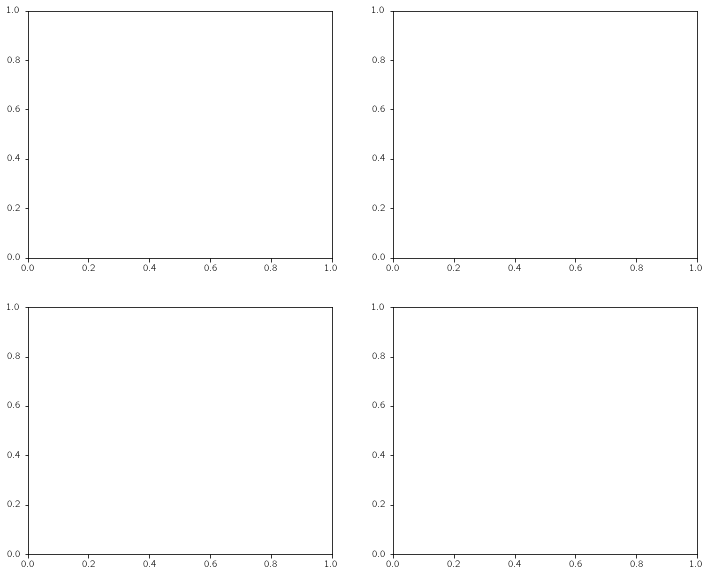

In [18]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [1., 1.]})

idx_att = np.where((data_att.binchoice == 1) & (data_att.x2 == -10))[0][0]
idx_noatt = np.where((data_noatt.binchoice == 1) & (data_noatt.x2 == -10))[0][0]
print(data_att.x2[idx_att], data_noatt.x2[idx_noatt])

ax1.plot(th[np.where(np.abs(th) < 40)], np.squeeze(r_sc_att[350, idx_att, np.where(np.abs(th) < 40)]), c='blue', lw=3)
ax1.plot(th[np.where(np.abs(th) < 40)], np.squeeze(r_sc_noatt[350, idx_noatt, np.where(np.abs(th) < 40)]), c='orange', lw=3)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax1.set_ylabel('Firing rate (Hz)', fontsize=15)

ax3.plot(th[np.where(np.abs(th) < 90)], np.squeeze(r_sc_att[350, idx_att, np.where(np.abs(th) < 90)]), c='blue', lw=3)
ax3.plot(th[np.where(np.abs(th) < 90)], np.squeeze(r_sc_noatt[350, idx_noatt, np.where(np.abs(th) < 90)]), c='orange', lw=3)

ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax3.set_ylabel('Firing rate (Hz)', fontsize=15)


#idx_att = 22
idx_att = np.where((data_att.binchoice == 1) & (data_att.x2 == 10))[0][0]
idx_noatt = np.where((data_noatt.binchoice == 1) & (data_noatt.x2 == 10))[0][0]
print(data_att.x2[idx_att], data_noatt.x2[idx_noatt])

ax2.plot(th[np.where(np.abs(th) < 40)], np.squeeze(r_sc_att[350, idx_att, np.where(np.abs(th) < 40)]), c='blue', lw=3)
ax2.plot(th[np.where(np.abs(th) < 40)], np.squeeze(r_sc_noatt[350, idx_noatt, np.where(np.abs(th) < 40)]), c='orange', lw=3)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax2.set_ylabel('Firing rate (Hz)', fontsize=15)

ax4.plot(th[np.where(np.abs(th) < 90)], np.squeeze(r_sc_att[350, idx_att, np.where(np.abs(th) < 90)]), c='blue', lw=3)
ax4.plot(th[np.where(np.abs(th) < 90)], np.squeeze(r_sc_noatt[350, idx_noatt, np.where(np.abs(th) < 90)]), c='orange', lw=3)

ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.set_xlabel('Preferred orientation $(^\circ)$', fontsize=15)
ax4.set_ylabel('Firing rate (Hz)', fontsize=15)

plt.show()

In [ ]:
ntrial = 3
print(data_att.loc[ntrial, ['x1', 'ph1', 'binchoice', 'x2', 'ph2', 'average']])
fig, ax1 = plot_bump_ic(data_att, r_ic_att, ntrial=ntrial)

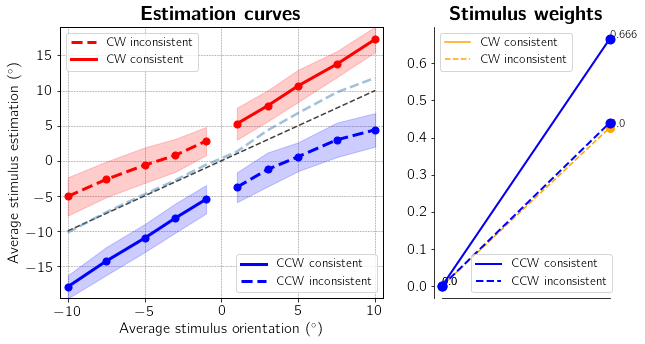

In [24]:
# attention at 40, 20, 30, 3.0, 3.0, sigma_stim = 15
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_002_nobump_att, df_002_nobump_att, save=True)

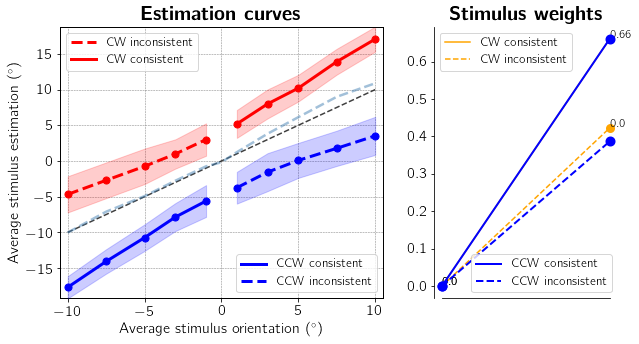

In [25]:
# attention at 40, 20, 30, 3.0, 3.0, sigma_stim = 15
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_005_nobump_att, df_005_nobump_att, save=True)

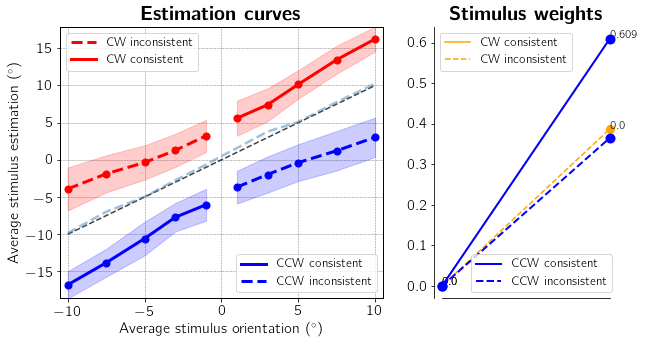

In [21]:
# attention at 40, 20, 30, 3.0, 3.0, sigma_stim = 15
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_010_nobump_att, df_010_nobump_att, save=True)

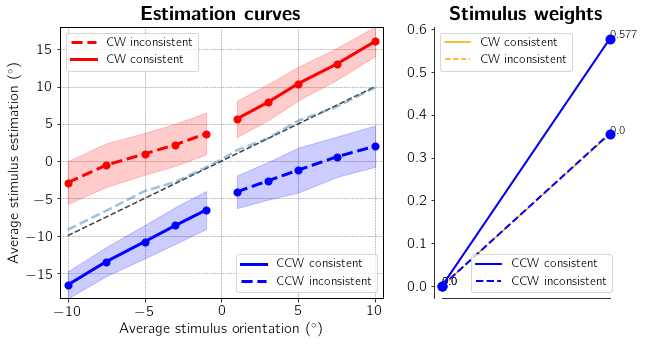

In [22]:
# attention at 40, 20, 30, 3.0, 3.0, sigma_stim = 15
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_015_nobump_att, df_015_nobump_att, save=True)

In [31]:
# now with a initial bump formed

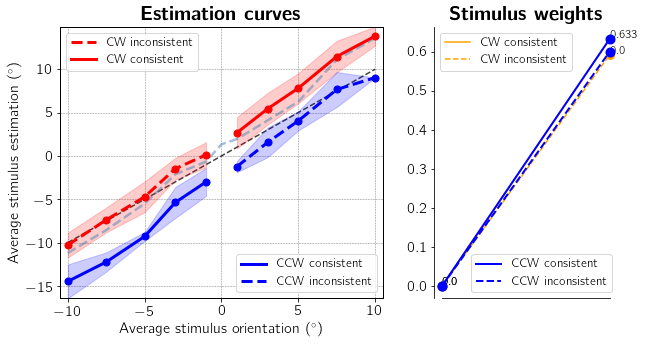

In [375]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_005_bump_att, df_005_bump_att, save=True)

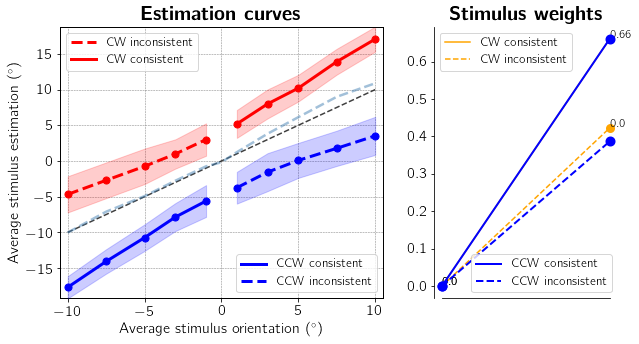

In [361]:
#attention at 40 and stronger
fig, [ax1, ax2] = plot_estimation_weights_consistent(data_att, data_att, save=True)

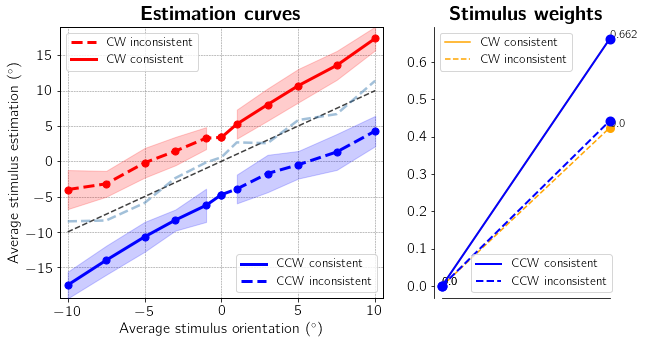

In [234]:
#attention at 45
fig, [ax1, ax2] = plot_estimation_weights_consistent(data_att, data_att, save=True)

In [397]:
#### changing functions for the tfm

In [402]:
def compute_weights_consistent(data):
    """Compute stimulus weights 
    
    :param pd.DataFrame data: dataframe containing the simulation results.
    :return: the weights of the different stimulus, their standard errors and their differences for choice and no-choice trials, respectively
    :rtype: (list of float, list of float, list of float)
    """
    consistent = data.loc[np.where((np.sign(data.binchoice) == np.sign(data.x2)) & (data.do_choice == 1))]
    inconsistent = data.loc[np.where((np.sign(data.binchoice) != np.sign(data.x2)) & (data.do_choice == 1))]
    labels = re.findall(r'x[0-9]+\b', '|'.join(data.columns))
    w, wse, dw = [], [], []

    for data in [consistent, inconsistent]:
        x, y = np.array(data[labels].astype(float)), np.array(data['estim'].astype(float))
        
        # Ordinary Least Squares
        res = sm.OLS(y, x).fit()
        w.append(res.params)
        wse.append(res.bse) # standard error of the parameters estimates
        dw.append(np.diff(res.params))  # difference between weights of stimulus

    return w, wse, dw

def plot_estimation_weights_consistent(data_est, data_w, save=False):
    """ Plotting of the estimation curves and the weights on the estimation of the different stimulus

    :param pd.DataFrame data: dataframe containing the simulation results.
    :param bool save: whether to save the graphics or not
    :return: the estimation curves as a function of the first stimulus and the weights of the different stimulus
    :rtype: 
    """
    
    data_cw = data_est.loc[data_est.binchoice == 1]
    data_ccw = data_est.loc[data_est.binchoice == -1]

    # for the estimation curves
    avg = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(np.mean).index.values
    est = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std = data_est.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_cw = data_cw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    avg_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).index.values
    est_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circmean, low=-180, high=180).values
    std_ccw = data_ccw.loc[:, ['average', 'estim']].groupby('average').estim.apply(circstd, low=-180, high=180).values

    # computation of the weights of the stimulus
    w, we, _ = compute_weights_consistent(data_w)
    w_cons, w_incons = np.array([w[0][0], w[0][1]]), np.array([w[1][0], w[1][1]])
    we_cons, we_incons = np.array([we[0][0], we[0][1]]), np.array([we[1][0], we[1][1]])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1.75, 1]})
        
    ax1.plot(avg, est, c='steelblue', alpha=0.5, lw=2.5, linestyle='dashed', zorder=5, label='_nolegend_')
    ax1.plot(np.linspace(np.min(avg), np.max(avg), 100), np.linspace(np.min(avg), np.max(avg), 100),
             '--', alpha=0.75, c='black', lw=1.5, label='_nolegend_')
    
    ax1.plot(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)], c='red', linestyle='dashed', alpha=1, lw=3, zorder=5)
    ax1.fill_between(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)] - std_cw[np.where(avg_cw < 0)], 
                     est_cw[np.where(avg_cw < 0)] + std_cw[np.where(avg_cw < 0)], color='red', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax1.plot(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)], c='red', linestyle='solid', alpha=1, lw=3, zorder=5)
    ax1.fill_between(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)], 
                     est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], color='red', alpha=0.2, label='_nolegend_', zorder=3)
    
    ax1.scatter(avg_cw[np.where(avg_cw < 0)], est_cw[np.where(avg_cw < 0)], c='red', s=50, zorder=5)
    ax1.scatter(avg_cw[np.where(avg_cw > 0)], est_cw[np.where(avg_cw > 0)], c='red', s=50, zorder=5)
    
    ax1.grid(color = 'grey', linestyle = 'dashed', linewidth = 0.5)
    
    #ax1.set_yticks(np.arange(np.min(data.x2), np.max(data.x2), 20))
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.set_xlabel('Average stimulus orientation $(^\circ)$', fontsize=15)
    ax1.set_ylabel('Average stimulus estimation $(^\circ)$', fontsize=15)

    ax1.set_title('\\textbf{Estimation curves}', fontsize=20)
    ax1.legend(['CW inconsistent', 'CW consistent'], fontsize=12.5, loc='upper left')
    ax1.set_xlim([np.min(data_est.average) - 0.5, np.max(data_est.average) + 0.5])
    ax1.set_ylim([np.min([np.concatenate([est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], 
                                          est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)]])]),   
                  np.max([np.concatenate([est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], 
                                          est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)]])])]) 
    
    ax3 = ax1.twinx().twiny()  # instantiate a second axes that shares the same x-axis
    
    ax3.plot(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)], c='blue', linestyle='solid', alpha=1, lw=3, zorder=5)
    ax3.fill_between(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)], 
                     est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], color='blue', alpha=0.2, label='_nolegend_', zorder=3)

    ax3.plot(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)], c='blue', linestyle='dashed', alpha=1, lw=3, zorder=5)
    ax3.fill_between(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)] - std_ccw[np.where(avg_ccw > 0)], 
                     est_ccw[np.where(avg_ccw > 0)] + std_ccw[np.where(avg_ccw > 0)], color='blue', alpha=0.2, label='_nolegend_', zorder=3)
    ax3.scatter(avg_ccw[np.where(avg_ccw < 0)], est_ccw[np.where(avg_ccw < 0)], c='blue', s=50, zorder=5)
    ax3.scatter(avg_ccw[np.where(avg_ccw > 0)], est_ccw[np.where(avg_ccw > 0)], c='blue', s=50, zorder=5)

    ax3.set_xlim([np.min(data_est.average) - 0.5, np.max(data_est.average) + 0.5])
    ax3.set_ylim([np.min([np.concatenate([est_ccw[np.where(avg_ccw < 0)] + std_ccw[np.where(avg_ccw < 0)], 
                                          est_ccw[np.where(avg_ccw < 0)] - std_ccw[np.where(avg_ccw < 0)]])]),   
                  np.max([np.concatenate([est_cw[np.where(avg_cw > 0)] + std_cw[np.where(avg_cw > 0)], 
                                          est_cw[np.where(avg_cw > 0)] - std_cw[np.where(avg_cw > 0)]])])]) 
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.legend(['CCW consistent', 'CCW inconsistent'], fontsize=12.5, loc='lower right')
    
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_cons, lw=1.5, c='orange')
    ax2.plot(np.array(['First\n stimulus', 'Second\n stimulus']), w_incons, lw=1.5, c='blue')

    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_cons, lw=3, c='orange')
    ax2.scatter(np.array(['First\n stimulus', 'Second\n stimulus']), w_incons, lw=3, c='blue')

    ax2.annotate(w_cons[0].round(3), (0, w_cons[0]), fontsize=12) 
    ax2.annotate(w_incons[0].round(3), (0, w_incons[0]), fontsize=12) 
    ax2.annotate(w_cons[1].round(3), (1, w_cons[1]), fontsize=12) 
    ax2.annotate(w_incons[1].round(3), (1, w_incons[1]), fontsize=12) 

    ax2.spines.top.set_visible(False)
    ax2.spines.bottom.set_visible(True)
    ax2.spines.left.set_visible(True)
    ax2.spines.right.set_visible(False)
    ax2.spines.bottom.set_bounds((0, 1))
    ax2.tick_params(axis='both', which='major', labelsize=15)

    ax2.set_title('\\textbf{Stimulus weights}', fontsize=20)
    ax2.legend(['Consistent', 'Inconsistent'], fontsize=12.5)
        
    if save == True:
        plt.savefig(f'/Users/miguel/Desktop/post_choice_bias/figs/est_consistent_i0-0.05_bump_biased.pdf', 
                    format='pdf', transparent=True)

    return fig, [ax1, ax2]

In [425]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/nobump_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_nobump_att = pd.read_csv('./pdb_nobump_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

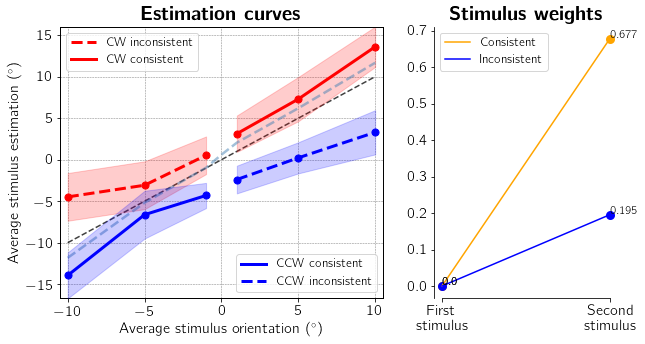

In [431]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_005_nobump_att, df_005_nobump_att, save=True)

In [450]:
os.chdir('/Users/miguel/Desktop/post_choice_bias/results/bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6')
df_005_bump_att = pd.read_csv('./pdb_bump_biased_attention-True_ntrials-300_oc-range(-20,20,5)_sigma-0.15_i0-0.05_frames-2_t-3.6.csv')

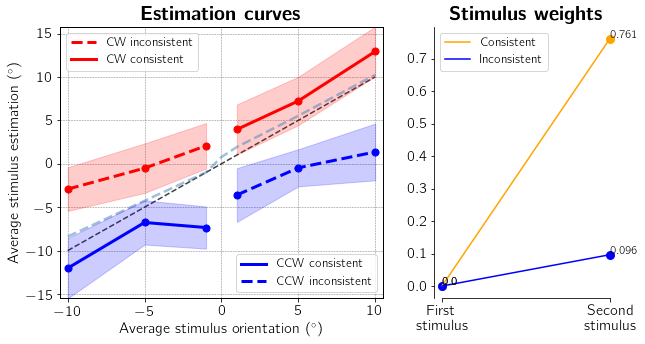

In [451]:
fig, [ax1, ax2] = plot_estimation_weights_consistent(df_005_bump_att, df_005_bump_att, save=True)

In [445]:
df_005_nobump_att[(df_005_nobump_att.binchoice == 1) & (df_005_nobump_att.average == -10)]

Trial  index  x1i  x2i   x1    x2  average  bincorrect  do_choice  \
15      15     15  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
26      26     26  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
46      46     46  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
84      84     84  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
107    107    107  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
114    114    114  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
166    166    166  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
173    173    173  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
223    223    223  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
235    235    235  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   
246    246    246  3.0  0.0  0.0 -20.0    -10.0         1.0        1.0   

     category  subj  init_ph_n     estim  binchoice   binrt       ph1  \
15      -10.0   1.0        1.0 -3.894142        1.0  0.2762  2.397500   
26      -10.0   1.0        1.0 -1.784032        1.0  0.2288  3.784286   
46      -10.0   1.0        1.0  2.621438        1.0  0.2346  4.285876   
84      -10.0   1.0        1.0 -5.485031        1.0  0.2758  1.232997   
107     -10.0   1.0        1.0 -5.918537        1.0  0.2654  2.040542   
114     -10.0   1.0        1.0 -7.451251        1.0  0.3518  0.060983   
166     -10.0   1.0        1.0 -3.650837        1.0  0.2276  4.161648   
173     -10.0   1.0        1.0 -6.265083        1.0  0.2942  0.119436   
223     -10.0   1.0        1.0 -3.306939        1.0  0.3008  1.229934   
235     -10.0   1.0        1.0 -6.035239        1.0  0.2676  1.962571   
246     -10.0   1.0        1.0 -8.114861        1.0  0.2766  1.751592   

          ph2       phd   ph_last  chosen  
15  -3.894142  2.695330 -4.021557      15  
26  -1.784032  4.038475 -2.000598      26  
46   2.621438  4.351857  2.393348      46  
84  -5.485031  1.640213 -5.657073      84  
107 -5.918537  2.544095 -6.026842     107  
114 -7.451251  0.283724 -7.574747     114  
166 -3.650837  4.360813 -3.858262     166  
173 -6.265083  0.539910 -6.419963     173  
223 -3.306939  1.579844 -3.457721     223  
235 -6.035239  2.353452 -6.192334     235  
246 -8.114861  2.047753 -8.296268     246